In [1]:
import networkx as nx
import osmnx as ox
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from itertools import permutations
from numpy import inf

In [2]:
#OK, let us start with the graphml file for London's underground

G = nx.read_graphml('london.graph.graphml')

In [3]:
G

In [4]:
type(G)

networkx.classes.graph.Graph

In [5]:
print(nx.info(G))

Graph with 401 nodes and 467 edges


<ipython-input-5-60d20efbd280>:1: DeprecationWarning: info is deprecated and will be removed in version 3.0.

  print(nx.info(G))


In [6]:
# To check node attributes:
list(G.nodes(data = True))[0]

('Wembley Park', {'coords': '(519316.5590174915, 186389.32981656672)'})

In [7]:
#since coords tuples are stored as string, need to convert them back to tuples using eval()
for node in G.nodes():
    G.nodes[node]['coords'] = eval(G.nodes[node]['coords'])

In [8]:
# To check node attributes:
list(G.nodes(data = True))[0]

('Wembley Park', {'coords': (519316.5590174915, 186389.32981656672)})

In [9]:
# To check edges attributes:
list(G.edges(data = True))[0]

('Wembley Park',
 'Kingsbury',
 {'length': 2916.7715580506483, 'line_name': 'Jubilee', 'flows': 12356})

In [10]:
# To check edges attributes: put initial and terminal station to the two side of edge like "A---B"
list(G.edges(data = True))[0]

('Wembley Park',
 'Kingsbury',
 {'length': 2916.7715580506483, 'line_name': 'Jubilee', 'flows': 12356})

In [11]:
deg_london =nx.degree_centrality(G)
nx.set_node_attributes(G,dict(deg_london),'degree')

In [12]:
deg_london =nx.degree_centrality(G)
nx.set_node_attributes(G,dict(deg_london),'degree')
# To dataframe using the nodes as the index
df = pd.DataFrame(index=G.nodes())
df['degree'] = pd.Series(nx.get_node_attributes(G, 'degree'))

df_sorted = df.sort_values(["degree"], ascending=False)
df_sorted[0:10]

,degree
Stratford,0.0225
Bank and Monument,0.0200
King's Cross St. Pancras,0.0175
Baker Street,0.0175
Earl's Court,0.0150
Oxford Circus,0.0150
Liverpool Street,0.0150
Waterloo,0.0150
Green Park,0.0150
Canning Town,0.0150


In [13]:
clos_t=nx.closeness_centrality(G)
# We can add these values to the nodes attributes:
nx.set_node_attributes(G,clos_t,'closeness_t')
df = pd.DataFrame(index=G.nodes())
# To ataframe using the nodes as the index

df['closeness_t'] = pd.Series(nx.get_node_attributes(G, 'closeness_t'))

df_sorted = df.sort_values(["closeness_t"], ascending=False)
df_sorted[0:10]

,closeness_t
Green Park,0.114778
Bank and Monument,0.113572
King's Cross St. Pancras,0.113443
Westminster,0.112549
Waterloo,0.112265
Oxford Circus,0.111204
Bond Street,0.110988
Farringdon,0.110742
Angel,0.110742
Moorgate,0.110314


In [14]:
#Let us compute the betweenness centrality for the network, without using weights:
bet_london_t=nx.betweenness_centrality(G, normalized=True)
# We can add these values to the nodes attributes:
nx.set_node_attributes(G,bet_london_t,'betweenness_t')
df = pd.DataFrame(index=G.nodes())
# To ataframe using the nodes as the index
df['betweenness_t'] = pd.Series(nx.get_node_attributes(G, 'betweenness_t'))

df_sorted = df.sort_values(["betweenness_t"], ascending=False)
df_sorted[0:10]

,betweenness_t
Stratford,0.297846
Bank and Monument,0.290489
Liverpool Street,0.270807
King's Cross St. Pancras,0.255307
Waterloo,0.243921
Green Park,0.215835
Euston,0.208324
Westminster,0.203335
Baker Street,0.191568
Finchley Road,0.165085


In [15]:
Gcc = sorted(nx.connected_components(G), key=len, reverse=True)
Gsub = G.subgraph(Gcc[0])

# calculate the percentage of nodes present in the largest connected components
percent_lcc = (len(Gsub.nodes)/len(G.nodes)) * 100

lb = '\n \t'
print(f'Largest Connected Compenent:{percent_lcc:.2f}%')
print(nx.info(Gsub))
print(f'Number of connected components:{nx.number_connected_components(Gsub)}')
print(f"Highest degree nodes: \n \t" \
        f"{lb.join(f'{hero[0]}: {hero[1]}' for hero in sorted(Gsub.degree(), key=lambda pair: pair[1], reverse=True)[0:5])}")

Largest Connected Compenent:100.00%
Graph with 401 nodes and 467 edges
Number of connected components:1
Highest degree nodes: 
 	Stratford: 9
 	Bank and Monument: 8
 	Baker Street: 7
 	King's Cross St. Pancras: 7
 	West Ham: 6


<ipython-input-15-056d3da8e130>:9: DeprecationWarning: info is deprecated and will be removed in version 3.0.

  print(nx.info(Gsub))


In [16]:
def global_efficiency(G):
    """Returns the average global efficiency of the graph.

    The *efficiency* of a pair of nodes in a graph is the multiplicative
    inverse of the shortest path distance between the nodes. The *average
    global efficiency* of a graph is the average efficiency of all pairs of
    nodes [1]_.

    Parameters
    ----------
    G : :class:`networkx.Graph`
        An undirected graph for which to compute the average global efficiency.

    Returns
    -------
    float
        The average global efficiency of the graph.

    Notes
    -----
    Edge weights are ignored when computing the shortest path distances.

    See also
    --------
    local_efficiency

    References
    ----------
    .. [1] Latora, Vito, and Massimo Marchiori.
           "Efficient behavior of small-world networks."
           *Physical Review Letters* 87.19 (2001): 198701.
           <https://doi.org/10.1103/PhysRevLett.87.198701>

    """
    n = len(G)
    denom = n * (n - 1)
    if denom != 0:
        lengths = nx.all_pairs_shortest_path_length(G)
        g_eff = 0
        for source, targets in lengths:
            for target, distance in targets.items():
                if distance > 0:
                    g_eff += 1 / distance
        g_eff /= denom
        # g_eff = sum(1 / d for s, tgts in lengths
        #                   for t, d in tgts.items() if d > 0) / denom
    else:
        g_eff = 0
    # TODO This can be made more efficient by computing all pairs shortest
    # path lengths in parallel.
    return g_eff

In [17]:
global_efficiency(G)

0.1012561935972123

In [18]:
average_coefficient=nx.average_clustering(G)
print(average_coefficient)

0.030382377389858693


In [19]:
betweenness_t_values=[(i[1]['betweenness_t']) for i in G.nodes(data=True)]

In [20]:
maxbet=[n for n in G.nodes() if G.nodes[n]['betweenness_t'] == max(betweenness_t_values)]
maxbet

['Stratford']

In [21]:
df.sort_values(by='betweenness_t',ascending=False).iloc[:10,:]

,betweenness_t
Stratford,0.297846
Bank and Monument,0.290489
Liverpool Street,0.270807
King's Cross St. Pancras,0.255307
Waterloo,0.243921
Green Park,0.215835
Euston,0.208324
Westminster,0.203335
Baker Street,0.191568
Finchley Road,0.165085


In [22]:
G2=nx.read_graphml('london.graph.graphml')

In [23]:
G2.remove_node('Stratford')
be1=global_efficiency(G2)
print(be1)
ba1=average_coefficient=nx.average_clustering(G2)
print(ba1)

0.08891736066510689
0.030625000000000003


In [24]:
G2.remove_node('Bank and Monument')
be2=global_efficiency(G2)
print(be2)
ba2=average_coefficient=nx.average_clustering(G2)
print(ba2)

0.08586164448742485
0.030027449576321755


In [25]:
G2.remove_node('Liverpool Street')
be3=global_efficiency(G2)
print(be3)
ba3=average_coefficient=nx.average_clustering(G2)
print(ba3)

0.08496349266423939
0.030102895429528594


In [26]:
G2.remove_node("King's Cross St. Pancras")
be4=global_efficiency(G2)
print(be4)
ba4=average_coefficient=nx.average_clustering(G2)
print(ba4)

0.07849775440713821
0.03034664747511095


In [27]:
G2.remove_node('Waterloo')
be5=global_efficiency(G2)
print(be5)
ba5=average_coefficient=nx.average_clustering(G2)
print(ba5)

0.07594226578366223
0.02932900432900433


In [28]:
G2.remove_node('Green Park')
be6=global_efficiency(G2)
print(be6)
ba6=average_coefficient=nx.average_clustering(G2)
print(ba6)

0.07415154167648695
0.028306208559373113


In [29]:
G2.remove_node('Euston')
be7=global_efficiency(G2)
print(be7)
ba7=average_coefficient=nx.average_clustering(G2)
print(ba7)

0.06820564659789057
0.024993956973652406


In [30]:
G2.remove_node('Westminster')
be8=global_efficiency(G2)
print(be8)
ba8=average_coefficient=nx.average_clustering(G2)
print(ba8)

0.06765950327361094
0.025057554828547195


In [31]:
G2.remove_node('Baker Street')
be9=global_efficiency(G2)
print(be9)
ba9=average_coefficient=nx.average_clustering(G2)
print(ba9)

0.064700058053009
0.021598639455782314


In [32]:
G2.remove_node('Finchley Road')
be10=global_efficiency(G2)
print(be10)
ba10=average_coefficient=nx.average_clustering(G2)
print(ba10)

0.06313903700825897
0.0216538789428815


In [33]:
efficiency_betweenness_list=[be1,be2,be3,be4,be5,be6,be7,be8,be9,be10]

In [34]:
efficiency_betweenness_list=[be1,be2,be3,be4,be5,be6,be7,be8,be9,be10]
coefficient_betweenness_list=[ba1,ba2,ba3,ba4,ba5,ba6,ba7,ba8,ba9,ba10]

In [35]:
data = {'B_efficiency': efficiency_betweenness_list , 'B_coefficient':coefficient_betweenness_list}

In [36]:
data = {'B_efficiency': efficiency_betweenness_list , 'B_coefficient':coefficient_betweenness_list}
df1 = pd.DataFrame(data)

In [37]:
df1

,B_efficiency,B_coefficient
0,0.088917,0.030625
1,0.085862,0.030027
2,0.084963,0.030103
3,0.078498,0.030347
4,0.075942,0.029329
5,0.074152,0.028306
6,0.068206,0.024994
7,0.067660,0.025058
8,0.064700,0.021599
9,0.063139,0.021654


In [38]:
G1=nx.read_graphml('london.graph.graphml')

In [39]:
G1.remove_node('Stratford')
de1=global_efficiency(G1)
print(de1)
da1=average_coefficient=nx.average_clustering(G1)
print(da1)

0.08891736066510689
0.030625000000000003


In [40]:
G1.remove_node('Bank and Monument')
de2=global_efficiency(G1)
print(de2)
da2=average_coefficient=nx.average_clustering(G1)
print(da2)

0.08586164448742485
0.030027449576321755


In [41]:
G1.remove_node("King's Cross St. Pancras")
de3=global_efficiency(G1)
print(de3)
da3=average_coefficient=nx.average_clustering(G1)
print(da3)

0.08028700838265396
0.030270399617133285


In [42]:
G1.remove_node('Baker Street')
de4=global_efficiency(G1)
print(de4)
da4=average_coefficient=nx.average_clustering(G1)
print(da4)

0.07570039409751211
0.027287993282955506


In [43]:
G1.remove_node("Earl's Court")
de5=global_efficiency(G1)
print(de5)
da5=average_coefficient=nx.average_clustering(G1)
print(da5)

0.0740361229198828
0.020538720538720537


In [44]:
G1.remove_node('Oxford Circus')
de6=global_efficiency(G1)
print(de6)
da6=average_coefficient=nx.average_clustering(G1)
print(da6)

0.07274535237569829
0.019071729957805903


In [45]:
G1.remove_node('Liverpool Street')
de7=global_efficiency(G1)
print(de7)
da7=average_coefficient=nx.average_clustering(G1)
print(da7)

0.07094844226118287
0.019120135363790182


In [46]:
G1.remove_node('Waterloo')
de8=global_efficiency(G1)
print(de8)
da8=average_coefficient=nx.average_clustering(G1)
print(da8)

0.06898194318071488
0.018066157760814248


In [47]:
G1.remove_node('Green Park')
de9=global_efficiency(G1)
print(de9)
da9=average_coefficient=nx.average_clustering(G1)
print(da9)

0.06825731584971681
0.019812925170068028


In [48]:
G1.remove_node('Canning Town')
de10=global_efficiency(G1)
print(de10)
da10=average_coefficient=nx.average_clustering(G1)
print(da10)

0.06338447666647608
0.016879795396419435


In [49]:
efficiency_degree_list=[de1,de2,de3,de4,de5,de6,de7,de8,de9,de10]
coefficient_degree_list=[da1,da2,da3,da4,da5,da6,da7,da8,da9,da10]

In [50]:
efficiency_degree_list=[de1,de2,de3,de4,de5,de6,de7,de8,de9,de10]
coefficient_degree_list=[da1,da2,da3,da4,da5,da6,da7,da8,da9,da10]
data = {'B_efficiency': efficiency_betweenness_list , 'B_coefficient':coefficient_betweenness_list,'D_efficiency':efficiency_degree_list , 'D_coefficient':coefficient_degree_list}
df1 = pd.DataFrame(data)

In [51]:
df1

,B_efficiency,B_coefficient,D_efficiency,D_coefficient
0,0.088917,0.030625,0.088917,0.030625
1,0.085862,0.030027,0.085862,0.030027
2,0.084963,0.030103,0.080287,0.030270
3,0.078498,0.030347,0.075700,0.027288
4,0.075942,0.029329,0.074036,0.020539
5,0.074152,0.028306,0.072745,0.019072
6,0.068206,0.024994,0.070948,0.019120
7,0.067660,0.025058,0.068982,0.018066
8,0.064700,0.021599,0.068257,0.019813
9,0.063139,0.021654,0.063384,0.016880


In [52]:
G3=nx.read_graphml('london.graph.graphml')

In [53]:
G3.remove_node('Green Park')
ce1=global_efficiency(G3)
print(ce1)
ca1=average_coefficient=nx.average_clustering(G3)
print(ca1)

0.09918991960788402
0.02979166666666667


In [54]:
G3.remove_node('Bank and Monument')
ce2=global_efficiency(G3)
print(ce2)
ca2=average_coefficient=nx.average_clustering(G3)
print(ca2)

0.09487232544791133
0.02927556987707364


In [55]:
G3.remove_node("King's Cross St. Pancras")
ce3=global_efficiency(G3)
print(ce3)
ca3=average_coefficient=nx.average_clustering(G3)
print(ca3)

0.08793385149140875
0.02951663077291218


In [56]:
G3.remove_node("Westminster")
ce4=global_efficiency(G3)
print(ce4)
ca4=average_coefficient=nx.average_clustering(G3)
print(ca4)

0.08737164566976727
0.028079644956219268


In [57]:
G3.remove_node("Waterloo")
ce5=global_efficiency(G3)
print(ce5)
ca5=average_coefficient=nx.average_clustering(G3)
print(ca5)

0.08485943799789313
0.028150553150553155


In [58]:
G3.remove_node("Oxford Circus")
ce6=global_efficiency(G3)
print(ce6)
ca6=average_coefficient=nx.average_clustering(G3)
print(ca6)

0.08278135073141742
0.02990958408679928


In [59]:
G3.remove_node("Bond Street")
ce7=global_efficiency(G3)
print(ce7)
ca7=average_coefficient=nx.average_clustering(G3)
print(ca7)

0.08258086417012774
0.030033840947546533


In [60]:
G3.remove_node("Farringdon")
ce8=global_efficiency(G3)
print(ce8)
ca8=average_coefficient=nx.average_clustering(G3)
print(ca8)

0.08260040537396239
0.030110262934690418


In [61]:
G3.remove_node("Angel")
ce9=global_efficiency(G3)
print(ce9)
ca9=average_coefficient=nx.average_clustering(G3)
print(ca9)

0.08262233108950982
0.030187074829931975


In [62]:
G3.remove_node("Moorgate")
ce10=global_efficiency(G3)
print(ce10)
ca10=average_coefficient=nx.average_clustering(G3)
print(ca10)

0.08166991436767818
0.030264279624893437


In [63]:
remove_station=[1,2,3,4,5,6,7,8,9,10]

In [64]:
efficiency_closeness_list=[ce1,ce2,ce3,ce4,ce5,ce6,ce7,ce8,ce9,ce10]
coefficient_closeness_list=[ca1,ca2,ca3,ca4,ca5,ca6,ca7,ca8,ca9,ca10]
data = {'Betweenness_efficiency': efficiency_betweenness_list , 'Betweenness_coefficient':coefficient_betweenness_list,'Degree_efficiency':efficiency_degree_list , 'Degree_coefficient':coefficient_degree_list , 'Closeness_efficiency':efficiency_closeness_list, 'Closeness_coefficient':coefficient_closeness_list, 'remove_stations':remove_station }
df1 = pd.DataFrame(data)

In [65]:
df1

,Betweenness_efficiency,Betweenness_coefficient,Degree_efficiency,Degree_coefficient,Closeness_efficiency,Closeness_coefficient,remove_stations
0,0.088917,0.030625,0.088917,0.030625,0.099190,0.029792,1
1,0.085862,0.030027,0.085862,0.030027,0.094872,0.029276,2
2,0.084963,0.030103,0.080287,0.030270,0.087934,0.029517,3
3,0.078498,0.030347,0.075700,0.027288,0.087372,0.028080,4
4,0.075942,0.029329,0.074036,0.020539,0.084859,0.028151,5
5,0.074152,0.028306,0.072745,0.019072,0.082781,0.029910,6
6,0.068206,0.024994,0.070948,0.019120,0.082581,0.030034,7
7,0.067660,0.025058,0.068982,0.018066,0.082600,0.030110,8
8,0.064700,0.021599,0.068257,0.019813,0.082622,0.030187,9
9,0.063139,0.021654,0.063384,0.016880,0.081670,0.030264,10


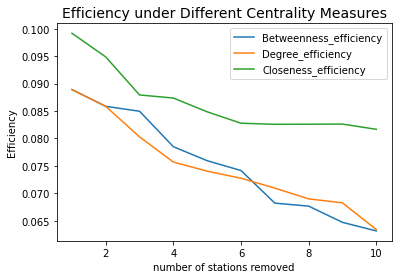

In [66]:
import pandas as pd
import matplotlib.pyplot as mp

# plot multiple columns such as population and year from dataframe
df1.plot(x="remove_stations", y=["Betweenness_efficiency","Degree_efficiency","Closeness_efficiency"])
# display plot
plt.title('Efficiency under Different Centrality Measures', fontsize=14)
plt.xlabel("number of stations removed", fontsize=10)
plt.ylabel("Efficiency", fontsize=10)
mp.show()

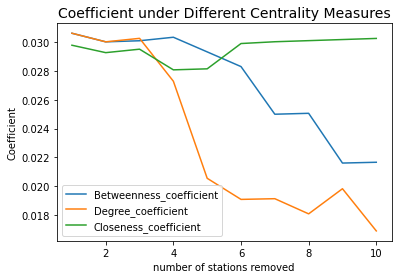

In [67]:

# plot multiple columns such as population and year from dataframe
df1.plot(x="remove_stations", y=["Betweenness_coefficient","Degree_coefficient","Closeness_coefficient"])
# display plot

plt.title('Coefficient under Different Centrality Measures', fontsize=14)
plt.xlabel("number of stations removed", fontsize=10)
plt.ylabel("Coefficient", fontsize=10)
mp.show()

In [68]:
G4 = nx.read_graphml('london.graph.graphml')
G5 = nx.read_graphml('london.graph.graphml')
G6 = nx.read_graphml('london.graph.graphml')

In [69]:
deg_london =nx.degree_centrality(G4)
nx.set_node_attributes(G4,dict(deg_london),'degree')
# To dataframe using the nodes as the index
df = pd.DataFrame(index=G4.nodes())
df['degree'] = pd.Series(nx.get_node_attributes(G4, 'degree'))

df_sorted = df.sort_values(["degree"], ascending=False)
df_sorted[0:10]

,degree
Stratford,0.0225
Bank and Monument,0.0200
King's Cross St. Pancras,0.0175
Baker Street,0.0175
Earl's Court,0.0150
Oxford Circus,0.0150
Liverpool Street,0.0150
Waterloo,0.0150
Green Park,0.0150
Canning Town,0.0150


In [70]:
G4.remove_node('Stratford')
de21=global_efficiency(G4)
print(de21)
da21=average_coefficient=nx.average_clustering(G4)
print(da21)

0.08891736066510689
0.030625000000000003


In [71]:
deg_london =nx.degree_centrality(G4)
nx.set_node_attributes(G4,dict(deg_london),'degree')
# To dataframe using the nodes as the index
df = pd.DataFrame(index=G4.nodes())
df['degree'] = pd.Series(nx.get_node_attributes(G4, 'degree'))

df_sorted = df.sort_values(["degree"], ascending=False)
df_sorted[0:10]

,degree
Bank and Monument,0.020050
King's Cross St. Pancras,0.017544
Baker Street,0.017544
Earl's Court,0.015038
Oxford Circus,0.015038
Canning Town,0.015038
Green Park,0.015038
Waterloo,0.015038
Liverpool Street,0.012531
Euston,0.012531


In [72]:
G4.remove_node('Bank and Monument')
de22=global_efficiency(G4)
print(de22)
da22=average_coefficient=nx.average_clustering(G4)
print(da22)

0.08586164448742485
0.030027449576321755


In [73]:
deg_london =nx.degree_centrality(G4)
nx.set_node_attributes(G4,dict(deg_london),'degree')
# To dataframe using the nodes as the index
df = pd.DataFrame(index=G4.nodes())
df['degree'] = pd.Series(nx.get_node_attributes(G4, 'degree'))

df_sorted = df.sort_values(["degree"], ascending=False)
df_sorted[0:10]

,degree
Baker Street,0.017588
King's Cross St. Pancras,0.017588
Oxford Circus,0.015075
Green Park,0.015075
Canning Town,0.015075
Earl's Court,0.015075
Turnham Green,0.012563
Euston,0.012563
Waterloo,0.012563
Willesden Junction,0.012563


In [74]:
G4.remove_node('Baker Street')
de23=global_efficiency(G4)
print(de23)
da23=average_coefficient=nx.average_clustering(G4)
print(da23)

0.08203328759057034
0.027051926298157458


In [75]:
deg_london =nx.degree_centrality(G4)
nx.set_node_attributes(G4,dict(deg_london),'degree')
# To dataframe using the nodes as the index
df = pd.DataFrame(index=G4.nodes())
df['degree'] = pd.Series(nx.get_node_attributes(G4, 'degree'))

df_sorted = df.sort_values(["degree"], ascending=False)
df_sorted[0:10]

,degree
King's Cross St. Pancras,0.017632
Earl's Court,0.015113
Oxford Circus,0.015113
Green Park,0.015113
Canning Town,0.015113
Willesden Junction,0.012594
Euston,0.012594
Waterloo,0.012594
Turnham Green,0.012594
West Ham,0.012594


In [76]:
G4.remove_node("King's Cross St. Pancras")
de24=global_efficiency(G4)
print(de24)
da24=average_coefficient=nx.average_clustering(G4)
print(da24)

0.07570039409751211
0.027287993282955506


In [77]:
deg_london =nx.degree_centrality(G4)
nx.set_node_attributes(G4,dict(deg_london),'degree')
# To dataframe using the nodes as the index
df = pd.DataFrame(index=G4.nodes())
df['degree'] = pd.Series(nx.get_node_attributes(G4, 'degree'))

df_sorted = df.sort_values(["degree"], ascending=False)
df_sorted[0:10]

,degree
Earl's Court,0.015152
Green Park,0.015152
Oxford Circus,0.015152
Canning Town,0.015152
Turnham Green,0.012626
West Ham,0.012626
Willesden Junction,0.012626
Waterloo,0.012626
Hammersmith,0.010101
Piccadilly Circus,0.010101


In [78]:
G4.remove_node("Earl's Court")
de25=global_efficiency(G4)
print(de25)
da25=average_coefficient=nx.average_clustering(G4)
print(da25)

0.0740361229198828
0.020538720538720537


In [79]:
deg_london =nx.degree_centrality(G4)
nx.set_node_attributes(G4,dict(deg_london),'degree')
# To dataframe using the nodes as the index
df = pd.DataFrame(index=G4.nodes())
df['degree'] = pd.Series(nx.get_node_attributes(G4, 'degree'))

df_sorted = df.sort_values(["degree"], ascending=False)
df_sorted[0:10]

,degree
Green Park,0.015190
Canning Town,0.015190
Oxford Circus,0.015190
Waterloo,0.012658
Willesden Junction,0.012658
Turnham Green,0.012658
West Ham,0.012658
Liverpool Street,0.010127
Hammersmith,0.010127
Holborn,0.010127


In [80]:
G4.remove_node("Green Park")
de26=global_efficiency(G4)
print(de26)
da26=average_coefficient=nx.average_clustering(G4)
print(da26)

0.07300367580539921
0.019493670886075946


In [81]:
deg_london =nx.degree_centrality(G4)
nx.set_node_attributes(G4,dict(deg_london),'degree')
# To dataframe using the nodes as the index
df = pd.DataFrame(index=G4.nodes())
df['degree'] = pd.Series(nx.get_node_attributes(G4, 'degree'))

df_sorted = df.sort_values(["degree"], ascending=False)
df_sorted[0:10]

,degree
Canning Town,0.015228
Waterloo,0.012690
Oxford Circus,0.012690
West Ham,0.012690
Willesden Junction,0.012690
Turnham Green,0.012690
Blackhorse Road,0.010152
Tottenham Court Road,0.010152
Holborn,0.010152
Liverpool Street,0.010152


In [82]:
G4.remove_node("Canning Town")
de27=global_efficiency(G4)
print(de27)
da27=average_coefficient=nx.average_clustering(G4)
print(da27)

0.0677717604548151
0.016582064297800337


In [83]:
deg_london =nx.degree_centrality(G4)
nx.set_node_attributes(G4,dict(deg_london),'degree')
# To dataframe using the nodes as the index
df = pd.DataFrame(index=G4.nodes())
df['degree'] = pd.Series(nx.get_node_attributes(G4, 'degree'))

df_sorted = df.sort_values(["degree"], ascending=False)
df_sorted[0:10]

,degree
Willesden Junction,0.012723
Turnham Green,0.012723
Waterloo,0.012723
Oxford Circus,0.012723
Wembley Park,0.010178
Tottenham Court Road,0.010178
Kennington,0.010178
West Hampstead,0.010178
Stockwell,0.010178
Holborn,0.010178


In [84]:
G4.remove_node("Willesden Junction")
de28=global_efficiency(G4)
print(de28)
da28=average_coefficient=nx.average_clustering(G4)
print(da28)

0.06012752519564628
0.01662425784563189


In [85]:
deg_london =nx.degree_centrality(G4)
nx.set_node_attributes(G4,dict(deg_london),'degree')
# To dataframe using the nodes as the index
df = pd.DataFrame(index=G4.nodes())
df['degree'] = pd.Series(nx.get_node_attributes(G4, 'degree'))

df_sorted = df.sort_values(["degree"], ascending=False)
df_sorted[0:10]

,degree
Turnham Green,0.012755
Oxford Circus,0.012755
Waterloo,0.012755
Camden Town,0.010204
Blackhorse Road,0.010204
Acton Town,0.010204
Finsbury Park,0.010204
Notting Hill Gate,0.010204
Hammersmith,0.010204
Euston,0.010204


In [86]:
G4.remove_node("Turnham Green")
de29=global_efficiency(G4)
print(de29)
da29=average_coefficient=nx.average_clustering(G4)
print(da29)

0.05814535563710196
0.01343537414965986


In [87]:
deg_london =nx.degree_centrality(G4)
nx.set_node_attributes(G4,dict(deg_london),'degree')
# To dataframe using the nodes as the index
df = pd.DataFrame(index=G4.nodes())
df['degree'] = pd.Series(nx.get_node_attributes(G4, 'degree'))

df_sorted = df.sort_values(["degree"], ascending=False)
df_sorted[0:10]

,degree
Oxford Circus,0.012788
Waterloo,0.012788
Wembley Park,0.010230
Camden Town,0.010230
Whitechapel,0.010230
Liverpool Street,0.010230
Shadwell,0.010230
Surrey Quays,0.010230
Holborn,0.010230
Tottenham Court Road,0.010230


In [88]:
G4.remove_node("Oxford Circus")
de210=global_efficiency(G4)
print(de210)
da210=average_coefficient=nx.average_clustering(G4)
print(da210)

0.05685866730429425
0.015174765558397271


In [89]:
clos_t=nx.closeness_centrality(G5)
# We can add these values to the nodes attributes:
nx.set_node_attributes(G5,clos_t,'closeness_t')
df = pd.DataFrame(index=G5.nodes())
# To ataframe using the nodes as the index

df['closeness_t'] = pd.Series(nx.get_node_attributes(G5, 'closeness_t'))

df_sorted = df.sort_values(["closeness_t"], ascending=False)
df_sorted[0:10]

,closeness_t
Green Park,0.114778
Bank and Monument,0.113572
King's Cross St. Pancras,0.113443
Westminster,0.112549
Waterloo,0.112265
Oxford Circus,0.111204
Bond Street,0.110988
Farringdon,0.110742
Angel,0.110742
Moorgate,0.110314


In [90]:
G5.remove_node("Green Park")
ce21=global_efficiency(G5)
print(ce21)
ca21=average_coefficient=nx.average_clustering(G5)
print(ca21)

0.09918991960788402
0.02979166666666667


In [91]:
clos_t=nx.closeness_centrality(G5)
# We can add these values to the nodes attributes:
nx.set_node_attributes(G5,clos_t,'closeness_t')
df = pd.DataFrame(index=G5.nodes())
# To ataframe using the nodes as the index

df['closeness_t'] = pd.Series(nx.get_node_attributes(G5, 'closeness_t'))

df_sorted = df.sort_values(["closeness_t"], ascending=False)
df_sorted[0:10]

,closeness_t
King's Cross St. Pancras,0.112363
Angel,0.110221
Farringdon,0.110221
Moorgate,0.109615
Bank and Monument,0.109435
Barbican,0.108897
Old Street,0.108897
Liverpool Street,0.107984
Euston,0.107576
Waterloo,0.107143


In [92]:
G5.remove_node("King's Cross St. Pancras")
ce22=global_efficiency(G5)
print(ce22)
ca22=average_coefficient=nx.average_clustering(G5)
print(ca22)

0.09443475025566316
0.03003341687552214


In [93]:
clos_t=nx.closeness_centrality(G5)
# We can add these values to the nodes attributes:
nx.set_node_attributes(G5,clos_t,'closeness_t')
df = pd.DataFrame(index=G5.nodes())
# To ataframe using the nodes as the index

df['closeness_t'] = pd.Series(nx.get_node_attributes(G5, 'closeness_t'))

df_sorted = df.sort_values(["closeness_t"], ascending=False)
df_sorted[0:10]

,closeness_t
Waterloo,0.104654
Bank and Monument,0.104489
Embankment,0.101868
Westminster,0.101350
Liverpool Street,0.101324
St. Paul's,0.099849
Charing Cross,0.098466
Moorgate,0.097933
Stratford,0.097549
Shadwell,0.097358


In [94]:
G5.remove_node("Waterloo")
ce23=global_efficiency(G5)
print(ce23)
ca23=average_coefficient=nx.average_clustering(G5)
print(ca23)

0.09181648060183005
0.028715003589375454


In [95]:
clos_t=nx.closeness_centrality(G5)
# We can add these values to the nodes attributes:
nx.set_node_attributes(G5,clos_t,'closeness_t')
df = pd.DataFrame(index=G5.nodes())
# To ataframe using the nodes as the index

df['closeness_t'] = pd.Series(nx.get_node_attributes(G5, 'closeness_t'))

df_sorted = df.sort_values(["closeness_t"], ascending=False)
df_sorted[0:10]

,closeness_t
Bank and Monument,0.097423
St. Paul's,0.096126
Oxford Circus,0.095663
Chancery Lane,0.095525
Holborn,0.095113
Tottenham Court Road,0.095044
Liverpool Street,0.094682
Bond Street,0.094569
Regent's Park,0.093149
Baker Street,0.092844


In [96]:
G5.remove_node("Bank and Monument")
ce24=global_efficiency(G5)
print(ce24)
ca24=average_coefficient=nx.average_clustering(G5)
print(ca24)

0.08542563066911478
0.028079644956219268


In [97]:
clos_t=nx.closeness_centrality(G5)
# We can add these values to the nodes attributes:
nx.set_node_attributes(G5,clos_t,'closeness_t')
df = pd.DataFrame(index=G5.nodes())
# To ataframe using the nodes as the index

df['closeness_t'] = pd.Series(nx.get_node_attributes(G5, 'closeness_t'))

df_sorted = df.sort_values(["closeness_t"], ascending=False)
df_sorted[0:10]

,closeness_t
West Hampstead,0.081734
Finchley Road & Frognal,0.080816
Hampstead Heath,0.080162
Gospel Oak,0.079742
Finchley Road,0.079662
Kensington,0.079518
West Brompton,0.079502
Brondesbury,0.079375
Shepherd's Bush,0.079295
Earl's Court,0.079248


In [98]:
G5.remove_node("West Hampstead")
ce25=global_efficiency(G5)
print(ce25)
ca25=average_coefficient=nx.average_clustering(G5)
print(ca25)

0.08054424756502003
0.028150553150553155


In [99]:
clos_t=nx.closeness_centrality(G5)
# We can add these values to the nodes attributes:
nx.set_node_attributes(G5,clos_t,'closeness_t')
df = pd.DataFrame(index=G5.nodes())
# To ataframe using the nodes as the index

df['closeness_t'] = pd.Series(nx.get_node_attributes(G5, 'closeness_t'))

df_sorted = df.sort_values(["closeness_t"], ascending=False)
df_sorted[0:10]

,closeness_t
Canada Water,0.075976
Surrey Quays,0.075540
Queens Road Peckham,0.075009
Peckham Rye,0.074782
West Brompton,0.074613
Denmark Hill,0.074556
Imperial Wharf,0.074500
Clapham Junction,0.074416
Wandsworth Road,0.074388
Clapham High Street,0.074332


In [100]:
G5.remove_node("Canada Water")
ce26=global_efficiency(G5)
print(ce26)
ca26=average_coefficient=nx.average_clustering(G5)
print(ca26)

0.05810104159173278
0.02822182037371911


In [101]:
clos_t=nx.closeness_centrality(G5)
# We can add these values to the nodes attributes:
nx.set_node_attributes(G5,clos_t,'closeness_t')
df = pd.DataFrame(index=G5.nodes())
# To ataframe using the nodes as the index

df['closeness_t'] = pd.Series(nx.get_node_attributes(G5, 'closeness_t'))

df_sorted = df.sort_values(["closeness_t"], ascending=False)
df_sorted[0:10]

,closeness_t
Stratford,0.063732
Earl's Court,0.063483
Notting Hill Gate,0.063109
High Street Kensington,0.062253
Shepherd's Bush,0.062223
Kensington,0.061302
Bayswater,0.060809
Gloucester Road,0.060752
Holland Park,0.060551
Willesden Junction,0.060324


In [102]:
G5.remove_node("Stratford")
ce27=global_efficiency(G5)
print(ce27)
ca27=average_coefficient=nx.average_clustering(G5)
print(ca27)

0.051883620553389555
0.028378051728305535


In [103]:
clos_t=nx.closeness_centrality(G5)
# We can add these values to the nodes attributes:
nx.set_node_attributes(G5,clos_t,'closeness_t')
df = pd.DataFrame(index=G5.nodes())
# To ataframe using the nodes as the index

df['closeness_t'] = pd.Series(nx.get_node_attributes(G5, 'closeness_t'))

df_sorted = df.sort_values(["closeness_t"], ascending=False)
df_sorted[0:10]

,closeness_t
Earl's Court,0.063645
Notting Hill Gate,0.063270
High Street Kensington,0.062411
Shepherd's Bush,0.062381
Kensington,0.061458
Bayswater,0.060964
Gloucester Road,0.060906
Holland Park,0.060705
Willesden Junction,0.060477
West Brompton,0.060392


In [104]:
G5.remove_node("Earl's Court")
ce28=global_efficiency(G5)
print(ce28)
ca28=average_coefficient=nx.average_clustering(G5)
print(ca28)

0.05035000093626794
0.021580031503695626


In [105]:
clos_t=nx.closeness_centrality(G5)
# We can add these values to the nodes attributes:
nx.set_node_attributes(G5,clos_t,'closeness_t')
df = pd.DataFrame(index=G5.nodes())
# To ataframe using the nodes as the index

df['closeness_t'] = pd.Series(nx.get_node_attributes(G5, 'closeness_t'))

df_sorted = df.sort_values(["closeness_t"], ascending=False)
df_sorted[0:10]

,closeness_t
Shepherd's Bush,0.060434
Notting Hill Gate,0.060235
Holland Park,0.059925
Willesden Junction,0.059177
Bayswater,0.058288
Paddington,0.057866
Queensway,0.057658
Kensal Green,0.056838
Edgware Road,0.056687
Bond Street,0.056487


In [106]:
G5.remove_node("Shepherd's Bush")
ce29=global_efficiency(G5)
print(ce29)
ca29=average_coefficient=nx.average_clustering(G5)
print(ca29)

0.04439458727102797
0.02163508260447036


In [107]:
clos_t=nx.closeness_centrality(G5)
# We can add these values to the nodes attributes:
nx.set_node_attributes(G5,clos_t,'closeness_t')
df = pd.DataFrame(index=G5.nodes())
# To ataframe using the nodes as the index

df['closeness_t'] = pd.Series(nx.get_node_attributes(G5, 'closeness_t'))

df_sorted = df.sort_values(["closeness_t"], ascending=False)
df_sorted[0:10]

,closeness_t
Oxford Circus,0.050501
Warren Street,0.049899
Paddington,0.049719
Baker Street,0.049668
Euston,0.049362
Edgware Road,0.049337
Bond Street,0.049185
Regent's Park,0.048861
South Hampstead,0.048008
Warwick Avenue,0.047651


In [108]:
G5.remove_node("Oxford Circus")
ce210=global_efficiency(G5)
print(ce210)
ca210=average_coefficient=nx.average_clustering(G5)
print(ca210)

0.04295771061337044
0.023395445134575574


In [109]:
#Let us compute the betweenness centrality for the network, without using weights:
bet_london_t=nx.betweenness_centrality(G6, normalized=True)
# We can add these values to the nodes attributes:
nx.set_node_attributes(G6,bet_london_t,'betweenness_t')
df = pd.DataFrame(index=G6.nodes())
# To ataframe using the nodes as the index
df['betweenness_t'] = pd.Series(nx.get_node_attributes(G6, 'betweenness_t'))

df_sorted = df.sort_values(["betweenness_t"], ascending=False)
df_sorted[0:10]

,betweenness_t
Stratford,0.297846
Bank and Monument,0.290489
Liverpool Street,0.270807
King's Cross St. Pancras,0.255307
Waterloo,0.243921
Green Park,0.215835
Euston,0.208324
Westminster,0.203335
Baker Street,0.191568
Finchley Road,0.165085


In [110]:
G6.remove_node("Stratford")
be21=global_efficiency(G6)
print(be21)
ba21=average_coefficient=nx.average_clustering(G6)
print(ba21)

0.08891736066510689
0.030625000000000003


In [111]:
bet_london_t=nx.betweenness_centrality(G6, normalized=True)
# We can add these values to the nodes attributes:
nx.set_node_attributes(G6,bet_london_t,'betweenness_t')
df = pd.DataFrame(index=G6.nodes())
# To ataframe using the nodes as the index
df['betweenness_t'] = pd.Series(nx.get_node_attributes(G6, 'betweenness_t'))

df_sorted = df.sort_values(["betweenness_t"], ascending=False)
df_sorted[0:10]

,betweenness_t
King's Cross St. Pancras,0.247262
Bank and Monument,0.203901
Euston,0.197493
Highbury & Islington,0.186195
Baker Street,0.172310
Waterloo,0.167415
Green Park,0.160526
Finsbury Park,0.154900
Finchley Road,0.153403
Canada Water,0.152583


In [112]:
G6.remove_node("King's Cross St. Pancras")
be22=global_efficiency(G6)
print(be22)
ba22=average_coefficient=nx.average_clustering(G6)
print(ba22)

0.08460293133575152
0.030868838763575608


In [113]:
bet_london_t=nx.betweenness_centrality(G6, normalized=True)
# We can add these values to the nodes attributes:
nx.set_node_attributes(G6,bet_london_t,'betweenness_t')
df = pd.DataFrame(index=G6.nodes())
# To ataframe using the nodes as the index
df['betweenness_t'] = pd.Series(nx.get_node_attributes(G6, 'betweenness_t'))

df_sorted = df.sort_values(["betweenness_t"], ascending=False)
df_sorted[0:10]

,betweenness_t
Waterloo,0.254180
Bank and Monument,0.242326
Green Park,0.230200
Westminster,0.217953
Finchley Road,0.182193
Baker Street,0.170352
West Hampstead,0.162842
Canada Water,0.156858
Willesden Junction,0.142845
Bond Street,0.139323


In [114]:
G6.remove_node("Waterloo")
be23=global_efficiency(G6)
print(be23)
ba23=average_coefficient=nx.average_clustering(G6)
print(ba23)

0.08182895253292936
0.02997128499641063


In [115]:
bet_london_t=nx.betweenness_centrality(G6, normalized=True)
# We can add these values to the nodes attributes:
nx.set_node_attributes(G6,bet_london_t,'betweenness_t')
df = pd.DataFrame(index=G6.nodes())
# To ataframe using the nodes as the index
df['betweenness_t'] = pd.Series(nx.get_node_attributes(G6, 'betweenness_t'))

df_sorted = df.sort_values(["betweenness_t"], ascending=False)
df_sorted[0:10]

,betweenness_t
Bank and Monument,0.214651
Finchley Road,0.191529
Canada Water,0.182385
Oxford Circus,0.182237
West Hampstead,0.179122
Baker Street,0.170824
Holborn,0.163805
Tottenham Court Road,0.160358
Chancery Lane,0.160332
St. Paul's,0.160239


In [116]:
G6.remove_node("Bank and Monument")
be24=global_efficiency(G6)
print(be24)
ba24=average_coefficient=nx.average_clustering(G6)
print(ba24)

0.07767794342812263
0.02925512774379273


In [117]:
bet_london_t=nx.betweenness_centrality(G6, normalized=True)
# We can add these values to the nodes attributes:
nx.set_node_attributes(G6,bet_london_t,'betweenness_t')
df = pd.DataFrame(index=G6.nodes())
# To ataframe using the nodes as the index
df['betweenness_t'] = pd.Series(nx.get_node_attributes(G6, 'betweenness_t'))

df_sorted = df.sort_values(["betweenness_t"], ascending=False)
df_sorted[0:10]

,betweenness_t
Canada Water,0.244903
West Hampstead,0.234500
Finchley Road,0.225894
Gospel Oak,0.206679
Finchley Road & Frognal,0.206372
Hampstead Heath,0.205426
Baker Street,0.183097
Canary Wharf,0.175385
Willesden Junction,0.158765
Surrey Quays,0.156046


In [118]:
G6.remove_node("Canada Water")
be25=global_efficiency(G6)
print(be25)
ba25=average_coefficient=nx.average_clustering(G6)
print(ba25)

0.07283234083472483
0.02932900432900433


In [119]:
bet_london_t=nx.betweenness_centrality(G6, normalized=True)
# We can add these values to the nodes attributes:
nx.set_node_attributes(G6,bet_london_t,'betweenness_t')
df = pd.DataFrame(index=G6.nodes())
# To ataframe using the nodes as the index
df['betweenness_t'] = pd.Series(nx.get_node_attributes(G6, 'betweenness_t'))

df_sorted = df.sort_values(["betweenness_t"], ascending=False)
df_sorted[0:10]

,betweenness_t
West Hampstead,0.456831
Finchley Road & Frognal,0.427784
Gospel Oak,0.427199
Hampstead Heath,0.426717
Finchley Road,0.320358
Highbury & Islington,0.275939
Kentish Town West,0.262289
Camden Road,0.260573
Caledonian Road & Barnsbury,0.259314
Baker Street,0.251800


In [120]:
G6.remove_node("West Hampstead")
be26=global_efficiency(G6)
print(be26)
ba26=average_coefficient=nx.average_clustering(G6)
print(ba26)

0.053210203984026455
0.029403254972875225


In [121]:
bet_london_t=nx.betweenness_centrality(G6, normalized=True)
# We can add these values to the nodes attributes:
nx.set_node_attributes(G6,bet_london_t,'betweenness_t')
df = pd.DataFrame(index=G6.nodes())
# To ataframe using the nodes as the index
df['betweenness_t'] = pd.Series(nx.get_node_attributes(G6, 'betweenness_t'))

df_sorted = df.sort_values(["betweenness_t"], ascending=False)
df_sorted[0:10]

,betweenness_t
Earl's Court,0.096182
Baker Street,0.087483
Willesden Junction,0.075457
Victoria,0.074618
West Brompton,0.071208
Wembley Park,0.067984
Finchley Road,0.067758
Shepherd's Bush,0.066210
Euston,0.066106
Green Park,0.060493


In [122]:
G6.remove_node("Earl's Court")
be27=global_efficiency(G6)
print(be27)
ba27=average_coefficient=nx.average_clustering(G6)
print(ba27)

0.05165629952389727
0.022625090645395213


In [123]:
bet_london_t=nx.betweenness_centrality(G6, normalized=True)
# We can add these values to the nodes attributes:
nx.set_node_attributes(G6,bet_london_t,'betweenness_t')
df = pd.DataFrame(index=G6.nodes())
# To ataframe using the nodes as the index
df['betweenness_t'] = pd.Series(nx.get_node_attributes(G6, 'betweenness_t'))

df_sorted = df.sort_values(["betweenness_t"], ascending=False)
df_sorted[0:10]

,betweenness_t
Shepherd's Bush,0.128852
Willesden Junction,0.103185
Baker Street,0.091497
Notting Hill Gate,0.086421
Holland Park,0.084128
Euston,0.071801
Kensington,0.071610
West Brompton,0.071221
Wembley Park,0.070142
Finchley Road,0.068446


In [124]:
G6.remove_node("Shepherd's Bush")
be28=global_efficiency(G6)
print(be28)
ba28=average_coefficient=nx.average_clustering(G6)
print(ba28)

0.0458442134055722
0.022682660850599782


In [125]:
bet_london_t=nx.betweenness_centrality(G6, normalized=True)
# We can add these values to the nodes attributes:
nx.set_node_attributes(G6,bet_london_t,'betweenness_t')
df = pd.DataFrame(index=G6.nodes())
# To ataframe using the nodes as the index
df['betweenness_t'] = pd.Series(nx.get_node_attributes(G6, 'betweenness_t'))

df_sorted = df.sort_values(["betweenness_t"], ascending=False)
df_sorted[0:10]

,betweenness_t
Euston,0.087075
Willesden Junction,0.077825
Baker Street,0.077746
Oxford Circus,0.075064
Green Park,0.070801
Warren Street,0.069234
Queen's Park,0.069218
Kensal Green,0.066694
Wembley Park,0.060137
Turnham Green,0.060065


In [126]:
G6.remove_node("Euston")
be29=global_efficiency(G6)
print(be29)
ba29=average_coefficient=nx.average_clustering(G6)
print(ba29)

0.04163076968121037
0.01933916423712342


In [127]:
bet_london_t=nx.betweenness_centrality(G6, normalized=True)
# We can add these values to the nodes attributes:
nx.set_node_attributes(G6,bet_london_t,'betweenness_t')
df = pd.DataFrame(index=G6.nodes())
# To ataframe using the nodes as the index
df['betweenness_t'] = pd.Series(nx.get_node_attributes(G6, 'betweenness_t'))

df_sorted = df.sort_values(["betweenness_t"], ascending=False)
df_sorted[0:10]

,betweenness_t
Baker Street,0.098437
Paddington,0.075592
Bond Street,0.068077
Edgware Road,0.066341
Green Park,0.062454
Acton Town,0.050712
Wembley Park,0.050587
Turnham Green,0.048652
Victoria,0.048180
West Ham,0.046402


In [128]:
G6.remove_node("Baker Street")
be210=global_efficiency(G6)
print(be210)
ba210=average_coefficient=nx.average_clustering(G6)
print(ba210)

0.0381637040943985
0.016283034953111678


In [129]:
sequential_efficiency_betweenness_list=[be21,be22,be23,be24,be25,be26,be27,be28,be29,be210]
sequential_coefficient_betweenness_list=[ba21,ba22,ba23,ba24,ba25,ba26,ba27,ba28,ba29,ba210]
sequential_efficiency_degree_list=[de21,de22,de23,de24,de25,de26,de27,de28,de29,de210]
sequential_coefficient_degree_list=[da21,da22,da23,da24,da25,da26,da27,da28,da29,da210]
sequential_coefficient_closeness_list=[ca21,ca22,ca23,ca24,ca25,ca26,ca27,ca28,ca29,ca210]
sequential_efficiency_closeness_list=[ce21,ce22,ce23,ce24,ce25,ce26,ce27,ce28,ce29,ce210]
                                    
                                    
data_sequential_coefficient= {'sequential_Betweenness': sequential_coefficient_betweenness_list , 'sequential_Degree':sequential_coefficient_degree_list, 'sequential_Closeness':sequential_coefficient_closeness_list,'remove_stations':remove_station }
data_sequential_efficiency= {'sequential_Betweenness': sequential_efficiency_betweenness_list , 'sequential_Degree':sequential_efficiency_degree_list, 'sequential_Closeness':sequential_efficiency_closeness_list,'remove_stations':remove_station }
df2 = pd.DataFrame(data_sequential_efficiency)
df3 = pd.DataFrame(data_sequential_coefficient)                               
                                    

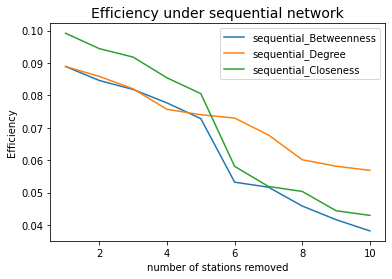

In [130]:
import pandas as pd
import matplotlib.pyplot as mp

# plot multiple columns such as population and year from dataframe
df2.plot(x="remove_stations", y=["sequential_Betweenness","sequential_Degree","sequential_Closeness"])
# display plot
plt.title('Efficiency under sequential network', fontsize=14)
plt.xlabel("number of stations removed", fontsize=10)
plt.ylabel("Efficiency", fontsize=10)
mp.show()

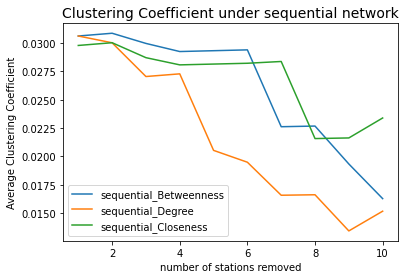

In [277]:


# plot multiple columns such as population and year from dataframe
df3.plot(x="remove_stations", y=["sequential_Betweenness","sequential_Degree","sequential_Closeness"])
# display plot
plt.title('Clustering Coefficient under sequential network', fontsize=14)
plt.xlabel("number of stations removed", fontsize=10)
plt.ylabel("Average Clustering Coefficient", fontsize=10)
mp.show()

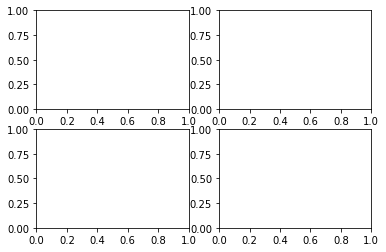

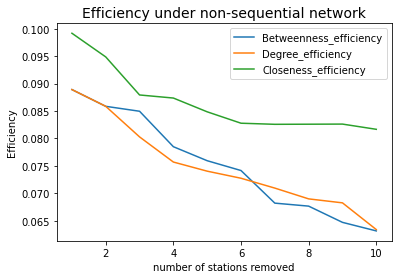

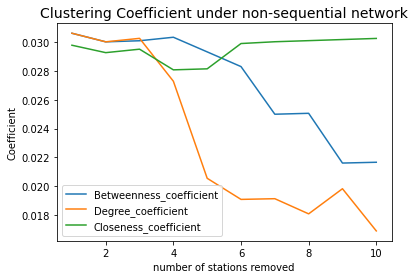

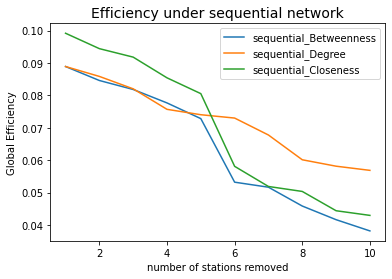

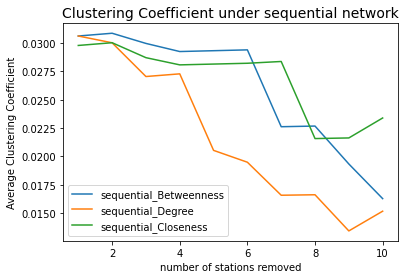

In [288]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(nrows=2, ncols=2)

# plot multiple columns such as population and year from dataframe
df1.plot(x="remove_stations", y=["Betweenness_efficiency","Degree_efficiency","Closeness_efficiency"])
# display plot
plt.title('Efficiency under non-sequential network', fontsize=14)
plt.xlabel("number of stations removed", fontsize=10)
plt.ylabel("Efficiency", fontsize=10)
mp.show()
# plot multiple columns such as population and year from dataframe
df1.plot(x="remove_stations", y=["Betweenness_coefficient","Degree_coefficient","Closeness_coefficient"])
# display plot

plt.title('Clustering Coefficient under non-sequential network', fontsize=14)
plt.xlabel("number of stations removed", fontsize=10)
plt.ylabel("Coefficient", fontsize=10)
mp.show()

# plot multiple columns such as population and year from dataframe
df2.plot(x="remove_stations", y=["sequential_Betweenness","sequential_Degree","sequential_Closeness"])
# display plot
plt.title('Efficiency under sequential network', fontsize=14)
plt.xlabel("number of stations removed", fontsize=10)
plt.ylabel("Global Efficiency", fontsize=10)
mp.show()
# plot multiple columns such as population and year from dataframe
df3.plot(x="remove_stations", y=["sequential_Betweenness","sequential_Degree","sequential_Closeness"])
# display plot
plt.title('Clustering Coefficient under sequential network', fontsize=14)
plt.xlabel("number of stations removed", fontsize=10)
plt.ylabel("Average Clustering Coefficient", fontsize=10)
mp.show()

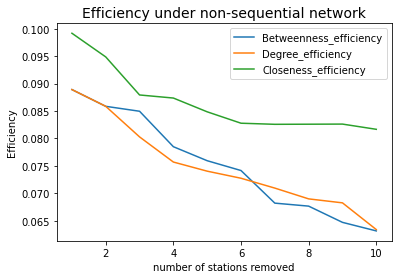

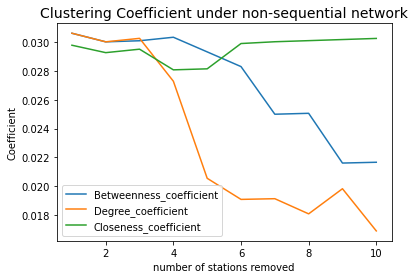

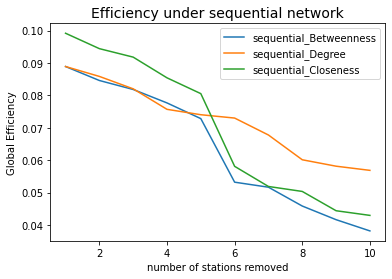

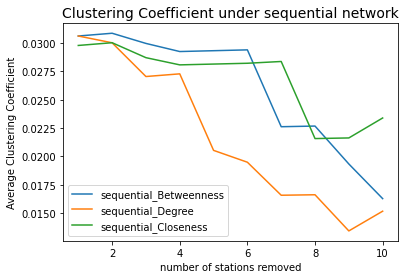

In [279]:
# plot multiple columns such as population and year from dataframe
df1.plot(x="remove_stations", y=["Betweenness_efficiency","Degree_efficiency","Closeness_efficiency"])
# display plot
plt.title('Efficiency under non-sequential network', fontsize=14)
plt.xlabel("number of stations removed", fontsize=10)
plt.ylabel("Efficiency", fontsize=10)
mp.show()
# plot multiple columns such as population and year from dataframe
df1.plot(x="remove_stations", y=["Betweenness_coefficient","Degree_coefficient","Closeness_coefficient"])
# display plot

plt.title('Clustering Coefficient under non-sequential network', fontsize=14)
plt.xlabel("number of stations removed", fontsize=10)
plt.ylabel("Coefficient", fontsize=10)
mp.show()

# plot multiple columns such as population and year from dataframe
df2.plot(x="remove_stations", y=["sequential_Betweenness","sequential_Degree","sequential_Closeness"])
# display plot
plt.title('Efficiency under sequential network', fontsize=14)
plt.xlabel("number of stations removed", fontsize=10)
plt.ylabel("Global Efficiency", fontsize=10)
mp.show()
# plot multiple columns such as population and year from dataframe
df3.plot(x="remove_stations", y=["sequential_Betweenness","sequential_Degree","sequential_Closeness"])
# display plot
plt.title('Clustering Coefficient under sequential network', fontsize=14)
plt.xlabel("number of stations removed", fontsize=10)
plt.ylabel("Average Clustering Coefficient", fontsize=10)
mp.show()

In [ ]:
df = pd.DataFrame({'speed': speed,
                   'lifespan': lifespan}, index=index)
ax = df.plot.bar(rot=0)

### Part1.1 end here#

In [133]:
Ga = nx.read_graphml('london.graph.graphml')

In [134]:
print(nx.info(Ga))

Graph with 401 nodes and 467 edges


<ipython-input-134-728b6df64494>:1: DeprecationWarning: info is deprecated and will be removed in version 3.0.

  print(nx.info(Ga))


In [135]:
inverse_flows={(e1, e2):round(1./(flows + 0.001),7) for e1, e2, flows in Ga.edges(data='flows')}

# Let us add the inversed weight as an attribute to the edges in the graph
nx.set_edge_attributes(Ga, inverse_flows, 'inverse_flows')

In [136]:
list(Ga.edges(data = True))[1]

('Wembley Park',
 'Neasden',
 {'length': 2353.1659381957816,
  'line_name': 'Jubilee',
  'flows': 6744,
  'inverse_flows': 0.0001483})

In [137]:
t_betweenness=nx.betweenness_centrality(Ga, normalized=True)
# We can add these values to the nodes attributes:
nx.set_node_attributes(Ga,t_betweenness,'betweenness_t')


In [138]:
df_Part2 = pd.DataFrame(index=Ga.nodes())
# To ataframe using the nodes as the index
df_Part2['betweenness_t'] = pd.Series(nx.get_node_attributes(Ga, 'betweenness_t'))

df_Part2_sorted= df_Part2.sort_values(["betweenness_t"], ascending=False)
df_Part2_sorted[0:10]

,betweenness_t
Stratford,0.297846
Bank and Monument,0.290489
Liverpool Street,0.270807
King's Cross St. Pancras,0.255307
Waterloo,0.243921
Green Park,0.215835
Euston,0.208324
Westminster,0.203335
Baker Street,0.191568
Finchley Road,0.165085


In [139]:
w_b=nx.betweenness_centrality(Ga, weight='inverse_flows')

In [140]:
nx.set_node_attributes(Ga,w_b,'Weighted_Betweenness')

In [141]:
w_b_df= pd.DataFrame.from_dict(dict(nx.get_node_attributes(Ga,'Weighted_Betweenness')),orient='index').sort_values(by=0,ascending=False)
w_b_df = w_b_df.rename(columns={0:"Weighted_Betweenness"})
w_b_df.head(10)

,Weighted_Betweenness
Green Park,0.572556
Bank and Monument,0.505288
Waterloo,0.416429
Westminster,0.381366
Liverpool Street,0.336817
Stratford,0.331291
Bond Street,0.291830
Euston,0.284236
Oxford Circus,0.270764
Warren Street,0.254286


In [142]:
###Remove from un-weighted graph ---- Stratford

In [143]:
Gs = nx.read_graphml('london.graph.graphml')
Gg = nx.read_graphml('london.graph.graphml')

In [144]:
Gs.remove_node('Stratford')

In [145]:
AC_Gs=nx.average_clustering(Gs, weight='inverse_flows')

print(AC_Gs)


0.030625000000000003


In [155]:
print(nx.is_connected(Gs))

False


In [156]:
nx.number_connected_components(Gs)

3

In [157]:
l3=list(Gs.nodes)
len(l3)

400

In [158]:
# To comput the size ( number of node) of each component
Subg = [Gs.subgraph(c).copy() for c in nx.connected_components(Gs)]
[len(subgraph.nodes) for subgraph in Subg]

[379, 20, 1]

In [159]:
# To obtain the largest component as a new graph: 

# Get the list of components:
components = nx.connected_components(Gs)
# Use the max() command to find the largest one:
largest_component = max(components, key=len)
# Create a "subgraph" of the largest component
Largest_subgraph = Gs.subgraph(largest_component)

In [160]:
list(Largest_subgraph.edges(data = True))[1]

('Wembley Park',
 'Neasden',
 {'length': 2353.1659381957816,
  'line_name': 'Jubilee',
  'flows': 6744,
  'inverse_flows': 0.0001483})

In [161]:
Largest_subgraph.number_of_nodes()

379

In [162]:
inverse_flows={(e1, e2):round(1./(flows + 0.001),7) for e1, e2, flows in Largest_subgraph.edges(data='flows')}

# Let us add the inversed weight as an attribute to the edges in the graph
nx.set_edge_attributes(Largest_subgraph, inverse_flows, 'inverse_flows')

In [164]:
AS_Gs=nx.average_shortest_path_length(Largest_subgraph)

In [165]:
print(AS_Gs)

14.496447069006436


In [166]:
###Remove from weighted graph ---- Green Park

In [167]:
Gg.remove_node('Green Park')

In [168]:
list(Gg.edges(data = True))[1]

('Wembley Park',
 'Neasden',
 {'length': 2353.1659381957816, 'line_name': 'Jubilee', 'flows': 6744})

In [169]:
inverse_flows={(e1, e2):round(1./(flows + 0.001),7) for e1, e2, flows in Gg.edges(data='flows')}

# Let us add the inversed weight as an attribute to the edges in the graph
nx.set_edge_attributes(Gg, inverse_flows, 'inverse_flows')

In [292]:
AS_Gs=nx.average_shortest_path_length(Largest_subgraph, weight='inverse_flows')
print(AC_Gs)
print(AS_Gs)

0.030625000000000003
21.08137421687572


In [170]:
AC_Gg=nx.average_clustering(Gg, nodes=None, weight='inverse_flows', count_zeros=True)
AS_Gg=nx.average_shortest_path_length(Gg, weight='inverse_flows', method=None)
print(AC_Gg)
print(AS_Gg)

7.551012931612477e-09
19.975776428484057


In [289]:
AC_Ga=nx.average_clustering(Ga, nodes=None, weight='inverse_flows', count_zeros=True)

In [290]:
AS_Ga=nx.average_shortest_path_length(Ga, weight='inverse_flows', method=None)

In [291]:
print(AC_Ga)
print(AS_Ga)

7.489652415674563e-09
19.925998498971584


### Network Finish here

## Spatial Interaction Models

In [172]:
from typing import Literal
import statsmodels.api as sm
import statsmodels.formula.api as smf


In [173]:
import scipy.stats

def CalcRSqaured(observed, estimated):
    """Calculate the r^2 from a series of observed and estimated target values
    inputs:
    Observed: Series of actual observed values
    estimated: Series of predicted values"""
    
    r, p = scipy.stats.pearsonr(observed, estimated)
    R2 = r **2
    
    return R2

In [174]:
from math import sqrt

def CalcRMSE(observed, estimated):
    """Calculate Root Mean Square Error between a series of observed and estimated values
    inputs:
    Observed: Series of actual observed values
    estimated: Series of predicted values"""
    
    res = (observed -estimated)**2
    RMSE = round(sqrt(res.mean()), 3)
    
    return RMSE

In [175]:
# Read in the edgelist file from csv
cdata = pd.read_csv("london_flows.csv")

# Print data (first five rows)
cdata.head(10)

,station_origin,station_destination,flows,population,jobs,distance
0,Abbey Road,Bank and Monument,0,599,78549,8131.525097
1,Abbey Road,Beckton,1,599,442,8510.121774
2,Abbey Road,Blackwall,3,599,665,3775.448872
3,Abbey Road,Canary Wharf,1,599,58772,5086.514220
4,Abbey Road,Canning Town,37,599,15428,2228.923167
5,Abbey Road,Crossharbour,1,599,1208,6686.475560
6,Abbey Road,Custom House,0,599,845,3824.855630
7,Abbey Road,Cutty Sark,2,599,1748,8503.898909
8,Abbey Road,Cyprus,7,599,850,6532.099618
9,Abbey Road,Devons Road,1,599,611,3958.324171


In [176]:
cdata.loc[~(cdata==0).all(axis=1)]

,station_origin,station_destination,flows,population,jobs,distance
0,Abbey Road,Bank and Monument,0,599,78549,8131.525097
1,Abbey Road,Beckton,1,599,442,8510.121774
2,Abbey Road,Blackwall,3,599,665,3775.448872
3,Abbey Road,Canary Wharf,1,599,58772,5086.514220
4,Abbey Road,Canning Town,37,599,15428,2228.923167
...,...,...,...,...,...,...
61469,Woolwich Arsenal,Tower Gateway,127,7892,3342,13401.795549
61470,Woolwich Arsenal,West Ham,608,7892,5487,8701.454361
61471,Woolwich Arsenal,West India Quay,6,7892,400,9536.720451
61472,Woolwich Arsenal,West Silvertown,81,7892,893,5355.248554


In [177]:
cdata.rename(columns = {"population": "Oi1_origpop","jobs":"Dj2_destjob", "distance":"Dist"}, inplace = True)

In [178]:
cdata= cdata[cdata['Oi1_origpop'] != 0]
cdata= cdata[cdata['Dj2_destjob'] != 0]
cdata= cdata[cdata['Dist'] != 0]

In [179]:
x_variables = ["Oi1_origpop", "Dj2_destjob", "Dist"]
log_x_vars = []
for x in x_variables:
    cdata[f"log_{x}"] = np.log(cdata[x])
    log_x_vars.append(f"log_{x}")

In [180]:
#create the formula
formula = 'flows ~ log_Oi1_origpop + log_Dj2_destjob + log_Dist'

#run the regression
uncosim = smf.glm(formula = formula, 
                  data=cdata,
                  family=sm.families.Poisson()).fit()


In [181]:
#first assign the parameter values from the model to the appropriate variables
K = uncosim.params[0]
alpha = uncosim.params[1]
gamma = uncosim.params[2]
beta = -uncosim.params[3]

#now plug everything back into the Equation 6 model ... 
#be careful with the negative signing of the parameter beta
cdata["unconstrainedEst2"] = np.exp(K 
                                       + alpha*cdata["log_Oi1_origpop"] 
                                       + gamma*cdata["log_Dj2_destjob"] 
                                       - beta*cdata["log_Dist"])

#or we can just extract the results from the actual poisson regression and apply them to the data
predictions = uncosim.get_prediction()
predictions_summary_frame = predictions.summary_frame()
cdata["fitted"] = predictions_summary_frame["mean"]

In [182]:
cdata.isnull().values.any()

False

In [183]:
#extract the summary of the constrained model
print(uncosim.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                  flows   No. Observations:                61413
Model:                            GLM   Df Residuals:                    61409
Model Family:                 Poisson   Df Model:                            3
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:            -1.2785e+06
Date:                Sat, 30 Apr 2022   Deviance:                   2.3848e+06
Time:                        11:56:10   Pearson chi2:                 4.76e+06
No. Iterations:                     6   Pseudo R-squ. (CS):              1.000
Covariance Type:            nonrobust                                         
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept          -3.7475      0.014   -2

In [184]:
uncosim.mu

array([49.61799552,  0.93719499,  2.12137455, ...,  5.34848651,
       14.11446759, 12.3877383 ])

In [185]:
#round the numbers so that we don't get a half of a person
cdata["unconstrainedEst2"] = round(cdata["unconstrainedEst2"], 0)
#convert to integers
cdata["unconstrainedEst2"] = cdata["unconstrainedEst2"].astype(int)
#check that the sum of these estimates make sense
sum(cdata["unconstrainedEst2"])

1542355

In [186]:
#turn it into a little matrix and have a look at your handy work
cdatasubmat2 = cdata.pivot_table(values ="unconstrainedEst2", index="station_origin", columns = "station_destination",
                            aggfunc=np.sum, margins=True)
cdatasubmat2

station_destination,Abbey Road,Acton Central,Acton Town,Aldgate,Aldgate East,All Saints,Alperton,Amersham,Anerley,Angel,...,Wimbledon,Wimbledon Park,Wood Green,Wood Lane,Wood Street,Woodford,Woodgrange Park,Woodside Park,Woolwich Arsenal,All
station_origin,,,,,,,,,,,,,,,,,,,,,
Abbey Road,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0,392
Acton Central,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,333
Acton Town,NaN,NaN,NaN,21.0,21.0,NaN,7.0,1.0,NaN,22.0,...,18.0,3.0,6.0,11.0,NaN,2.0,NaN,3.0,NaN,3862
Aldgate,NaN,NaN,7.0,NaN,81.0,NaN,NaN,1.0,NaN,47.0,...,14.0,NaN,8.0,6.0,NaN,3.0,NaN,3.0,NaN,6107
Aldgate East,NaN,NaN,7.0,85.0,NaN,NaN,3.0,1.0,NaN,48.0,...,14.0,3.0,8.0,7.0,NaN,3.0,NaN,3.0,NaN,6470
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Woodford,NaN,NaN,7.0,26.0,28.0,NaN,NaN,NaN,NaN,25.0,...,14.0,NaN,8.0,NaN,NaN,NaN,NaN,NaN,NaN,3707
Woodgrange Park,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,62
Woodside Park,NaN,NaN,5.0,18.0,18.0,NaN,2.0,NaN,NaN,21.0,...,11.0,NaN,6.0,NaN,NaN,NaN,NaN,NaN,NaN,2648


In [187]:
CalcRSqaured(cdata["flows"], cdata["unconstrainedEst2"])

0.32119035773617916

In [188]:
CalcRMSE(cdata["flows"], cdata["unconstrainedEst2"])

108.334

In [189]:
###4.1

In [190]:
cdatasub=cdata

In [191]:
cdatasub.rename(columns = {"flows": "Total"}, inplace = True)

In [192]:
#create the formula (the "-1" indicates no intercept in the regression model).
formula = 'Total ~ station_origin + log_Dj2_destjob + log_Dist-1'
#run a production constrained sim
prodSim = smf.glm(formula = formula, data=cdatasub, family=sm.families.Poisson()).fit()
#let's have a look at it's summary
print(prodSim.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                  Total   No. Observations:                61413
Model:                            GLM   Df Residuals:                    61013
Model Family:                 Poisson   Df Model:                          399
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:            -1.0169e+06
Date:                Sat, 30 Apr 2022   Deviance:                   1.8615e+06
Time:                        11:56:38   Pearson chi2:                 2.78e+06
No. Iterations:                     8   Pseudo R-squ. (CS):              1.000
Covariance Type:            nonrobust                                         
                                                  coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------

In [193]:
#create some Oi and Dj columns in the dataframe and store row and column totals in them:
#to create O_i, take cdatasub ...then... group by origcodenew ...then... summarise by calculating the sum of Total
O_i = pd.DataFrame(cdatasub.groupby(["station_origin"])["Total"].agg(np.sum))
O_i.rename(columns={"Total":"O_i"}, inplace = True)
cdatasub = cdatasub.merge(O_i, on = "station_origin", how = "left" )

D_j = pd.DataFrame(cdatasub.groupby(["station_destination"])["Total"].agg(np.sum))
D_j.rename(columns={"Total":"D_j"}, inplace = True)
cdatasub = cdatasub.merge(D_j, on = "station_destination", how = "left" )

In [194]:
#We can do this by pulling out the parameter values
coefs = pd.DataFrame(prodSim.params)
coefs.reset_index(inplace=True)
coefs.rename(columns = {0:"alpha_i", "index":"coef"}, inplace = True)
to_repl = ["(station_origin)", "\[", "\]"]
for x in to_repl:
    coefs["coef"] = coefs["coef"].str.replace(x, "")
#then once you have done this you can join them back into the dataframes
cdatasub = cdatasub.merge(coefs, left_on="station_origin", right_on="coef", how = "left")
cdatasub.drop(columns = ["coef"], inplace = True)
#check this has worked
cdatasub.head()

<ipython-input-194-80d827ae8f40>:7: FutureWarning: The default value of regex will change from True to False in a future version.
  coefs["coef"] = coefs["coef"].str.replace(x, "")


,station_origin,station_destination,Total,Oi1_origpop,Dj2_destjob,Dist,log_Oi1_origpop,log_Dj2_destjob,log_Dist,unconstrainedEst2,fitted,O_i,D_j,alpha_i
0,Abbey Road,Bank and Monument,0,599,78549,8131.525097,6.395262,11.271478,9.003504,50,49.617996,599,78549,3.250242
1,Abbey Road,Beckton,1,599,442,8510.121774,6.395262,6.091310,9.049012,1,0.937195,599,442,3.250242
2,Abbey Road,Blackwall,3,599,665,3775.448872,6.395262,6.499787,8.236275,2,2.121375,599,665,3.250242
3,Abbey Road,Canary Wharf,1,599,58772,5086.514220,6.395262,10.981421,8.534348,53,53.297014,599,58772,3.250242
4,Abbey Road,Canning Town,37,599,15428,2228.923167,6.395262,9.643939,7.709274,32,32.208586,599,15428,3.250242


In [195]:
alpha_i = prodSim.params[0:7]
gamma = prodSim.params[7]
beta = -prodSim.params[8]

In [196]:
cdatasub["prodsimest1"] = np.exp(cdatasub["alpha_i"]+gamma*cdatasub["log_Dj2_destjob"] 
                                 - beta*cdatasub["log_Dist"])
#or you could do it the easy way like we did last week with the fitted column (See previous practical)
cdatasub.head(10)

,station_origin,station_destination,Total,Oi1_origpop,Dj2_destjob,Dist,log_Oi1_origpop,log_Dj2_destjob,log_Dist,unconstrainedEst2,fitted,O_i,D_j,alpha_i,prodsimest1
0,Abbey Road,Bank and Monument,0,599,78549,8131.525097,6.395262,11.271478,9.003504,50,49.617996,599,78549,3.250242,1.373352e+44
1,Abbey Road,Beckton,1,599,442,8510.121774,6.395262,6.091310,9.049012,1,0.937195,599,442,3.250242,7.546628e+33
2,Abbey Road,Blackwall,3,599,665,3775.448872,6.395262,6.499787,8.236275,2,2.121375,599,665,3.250242,7.468786e+32
3,Abbey Road,Canary Wharf,1,599,58772,5086.514220,6.395262,10.981421,8.534348,53,53.297014,599,58772,3.250242,3.206658e+42
4,Abbey Road,Canning Town,37,599,15428,2228.923167,6.395262,9.643939,7.709274,32,32.208586,599,15428,3.250242,9.581012e+37
5,Abbey Road,Crossharbour,1,599,1208,6686.475560,6.395262,7.096721,8.807842,2,2.340152,599,1208,3.250242,2.230335e+35
6,Abbey Road,Custom House,0,599,845,3824.855630,6.395262,6.739337,8.249276,3,2.524914,599,845,3.250242,2.407507e+33
7,Abbey Road,Cutty Sark,2,599,1748,8503.898909,6.395262,7.466228,9.048280,3,2.668661,599,1748,3.250242,4.230554e+36
8,Abbey Road,Cyprus,7,599,850,6532.099618,6.395262,6.745236,8.784484,2,1.817327,599,850,3.250242,3.916805e+34
9,Abbey Road,Devons Road,1,599,611,3958.324171,6.395262,6.415097,8.283576,2,1.931266,599,611,3.250242,6.454449e+32


In [197]:
cdatasub["prodsimest1"] = np.exp(cdatasub["alpha_i"]+gamma*cdatasub["log_Dj2_destjob"] 
                                 - beta*cdatasub["log_Dist"])
#or you could do it the easy way like we did last week with the fitted column (See previous practical)
cdatasub.head(10)

,station_origin,station_destination,Total,Oi1_origpop,Dj2_destjob,Dist,log_Oi1_origpop,log_Dj2_destjob,log_Dist,unconstrainedEst2,fitted,O_i,D_j,alpha_i,prodsimest1
0,Abbey Road,Bank and Monument,0,599,78549,8131.525097,6.395262,11.271478,9.003504,50,49.617996,599,78549,3.250242,1.373352e+44
1,Abbey Road,Beckton,1,599,442,8510.121774,6.395262,6.091310,9.049012,1,0.937195,599,442,3.250242,7.546628e+33
2,Abbey Road,Blackwall,3,599,665,3775.448872,6.395262,6.499787,8.236275,2,2.121375,599,665,3.250242,7.468786e+32
3,Abbey Road,Canary Wharf,1,599,58772,5086.514220,6.395262,10.981421,8.534348,53,53.297014,599,58772,3.250242,3.206658e+42
4,Abbey Road,Canning Town,37,599,15428,2228.923167,6.395262,9.643939,7.709274,32,32.208586,599,15428,3.250242,9.581012e+37
5,Abbey Road,Crossharbour,1,599,1208,6686.475560,6.395262,7.096721,8.807842,2,2.340152,599,1208,3.250242,2.230335e+35
6,Abbey Road,Custom House,0,599,845,3824.855630,6.395262,6.739337,8.249276,3,2.524914,599,845,3.250242,2.407507e+33
7,Abbey Road,Cutty Sark,2,599,1748,8503.898909,6.395262,7.466228,9.048280,3,2.668661,599,1748,3.250242,4.230554e+36
8,Abbey Road,Cyprus,7,599,850,6532.099618,6.395262,6.745236,8.784484,2,1.817327,599,850,3.250242,3.916805e+34
9,Abbey Road,Devons Road,1,599,611,3958.324171,6.395262,6.415097,8.283576,2,1.931266,599,611,3.250242,6.454449e+32


In [198]:
CalcRSqaured(cdatasub["Total"], cdatasub["prodsimest1"])

0.0002686797263581537

In [199]:
CalcRMSE(cdatasub["Total"], cdatasub["prodsimest1"])

3.2312356491982854e+46

In [200]:
def new_sal(row):
    if row["station_destination"] == "Canary Wharf":
        val = 29386
    else:
        val = row["Dj2_destjob"]
    return val
        
cdatasub["Dj3_destjobScenario"] = cdatasub.apply(new_sal, axis =1)
cdatasub.head(10)

,station_origin,station_destination,Total,Oi1_origpop,Dj2_destjob,Dist,log_Oi1_origpop,log_Dj2_destjob,log_Dist,unconstrainedEst2,fitted,O_i,D_j,alpha_i,prodsimest1,Dj3_destjobScenario
0,Abbey Road,Bank and Monument,0,599,78549,8131.525097,6.395262,11.271478,9.003504,50,49.617996,599,78549,3.250242,1.373352e+44,78549
1,Abbey Road,Beckton,1,599,442,8510.121774,6.395262,6.091310,9.049012,1,0.937195,599,442,3.250242,7.546628e+33,442
2,Abbey Road,Blackwall,3,599,665,3775.448872,6.395262,6.499787,8.236275,2,2.121375,599,665,3.250242,7.468786e+32,665
3,Abbey Road,Canary Wharf,1,599,58772,5086.514220,6.395262,10.981421,8.534348,53,53.297014,599,58772,3.250242,3.206658e+42,29386
4,Abbey Road,Canning Town,37,599,15428,2228.923167,6.395262,9.643939,7.709274,32,32.208586,599,15428,3.250242,9.581012e+37,15428
5,Abbey Road,Crossharbour,1,599,1208,6686.475560,6.395262,7.096721,8.807842,2,2.340152,599,1208,3.250242,2.230335e+35,1208
6,Abbey Road,Custom House,0,599,845,3824.855630,6.395262,6.739337,8.249276,3,2.524914,599,845,3.250242,2.407507e+33,845
7,Abbey Road,Cutty Sark,2,599,1748,8503.898909,6.395262,7.466228,9.048280,3,2.668661,599,1748,3.250242,4.230554e+36,1748
8,Abbey Road,Cyprus,7,599,850,6532.099618,6.395262,6.745236,8.784484,2,1.817327,599,850,3.250242,3.916805e+34,850
9,Abbey Road,Devons Road,1,599,611,3958.324171,6.395262,6.415097,8.283576,2,1.931266,599,611,3.250242,6.454449e+32,611


In [201]:
cdatasub["prodsimest2"] = np.exp(cdatasub["alpha_i"]+gamma*np.log(cdatasub["Dj3_destjobScenario"]) - beta*cdatasub["log_Dist"])

cdatasub["prodsimest2"] = round(cdatasub["prodsimest2"],0)
#now we can convert the pivot table into a matrix
cdatasubmat4 = cdatasub.pivot_table(values ="prodsimest2", index="station_origin", columns = "station_destination",
                            aggfunc=np.sum, margins=True)
cdatasubmat4

station_destination,Abbey Road,Acton Central,Acton Town,Aldgate,Aldgate East,All Saints,Alperton,Amersham,Anerley,Angel,...,Wimbledon,Wimbledon Park,Wood Green,Wood Lane,Wood Street,Woodford,Woodgrange Park,Woodside Park,Woolwich Arsenal,All
station_origin,,,,,,,,,,,,,,,,,,,,,
Abbey Road,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.683574e+38,1.374698e+44
Acton Central,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,1.008171e+36,NaN,NaN,3.068501e+46
Acton Town,NaN,NaN,NaN,5.355257e+41,6.291596e+41,NaN,1.893725e+34,4.750882e+36,NaN,4.444637e+41,...,1.354778e+41,1.467340e+36,6.932621e+39,2.169865e+36,NaN,2.088641e+38,NaN,1.011223e+38,NaN,4.524941e+46
Aldgate,NaN,NaN,4.627312e+38,NaN,4.986776e+35,NaN,NaN,3.643627e+36,NaN,5.701097e+37,...,1.078023e+41,NaN,9.058581e+37,2.005893e+37,NaN,1.708429e+36,NaN,3.551158e+36,NaN,2.474279e+43
Aldgate East,NaN,NaN,5.692066e+38,5.221321e+35,NaN,NaN,1.400566e+37,4.282833e+36,NaN,9.199588e+37,...,1.315320e+41,1.595566e+36,1.142943e+38,2.535309e+37,NaN,1.194133e+36,NaN,4.363109e+36,NaN,1.507344e+43
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Woodford,NaN,NaN,7.158908e+40,6.776904e+41,4.524042e+41,NaN,NaN,NaN,NaN,1.596680e+42,...,1.267460e+43,NaN,1.067252e+40,NaN,NaN,NaN,NaN,NaN,NaN,5.359662e+46
Woodgrange Park,NaN,2.341177e+38,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.061515e+43
Woodside Park,NaN,NaN,1.704619e+40,6.927900e+41,8.129564e+41,NaN,2.778323e+38,NaN,NaN,3.130408e+41,...,3.228769e+42,NaN,5.721900e+39,NaN,NaN,NaN,NaN,NaN,NaN,6.449312e+46


In [202]:
#calculate some new wj^alpha and d_ij^beta values
Dj2_gamma = cdatasub["Dj2_destjob"]**gamma
dist_beta = cdatasub["Dist"]**beta
#calcualte the first stage of the Ai values
cdatasub["Ai1"] = Dj2_gamma * dist_beta
#now do the sum over all js bit
A_i = pd.DataFrame(cdatasub.groupby(["station_origin"])["Ai1"].agg(np.sum))
#now divide into 1
A_i["Ai1"] = 1/A_i["Ai1"]
A_i.rename(columns={"Ai1":"A_i"}, inplace=True)
#and write the A_i values back into the dataframe
cdatasub = cdatasub.merge(A_i, left_on="station_origin", right_index=True, how="left")

In [203]:
#to check everything works, recreate the original estimates
cdatasub["prodsimest3"] = cdatasub["A_i"]*cdatasub["O_i"]*Dj2_gamma*dist_beta
#round
cdatasub["prodsimest3"] = round(cdatasub["prodsimest3"])
#check
cdatasub[["prodsimest1", "prodsimest3"]]

,prodsimest1,prodsimest3
0,1.373352e+44,0.0
1,7.546628e+33,0.0
2,7.468786e+32,0.0
3,3.206658e+42,0.0
4,9.581012e+37,0.0
...,...,...
61408,3.386793e+40,0.0
61409,3.577330e+40,0.0
61410,3.317392e+35,0.0
61411,6.821941e+35,0.0


In [204]:
#calculate some new wj^alpha and d_ij^beta values
Dj3_gamma = cdatasub["Dj3_destjobScenario"]**gamma
#calcualte the first stage of the Ai values
cdatasub["Ai1"] = Dj3_gamma * dist_beta
#now do the sum over all js bit
A_i = pd.DataFrame(cdatasub.groupby(["station_origin"])["Ai1"].agg(np.sum))
#now divide into 1
A_i["Ai1"] = 1/A_i["Ai1"]
A_i.rename(columns={"Ai1":"A_i2"}, inplace=True)
#and write the A_i values back into the dataframe
cdatasub = cdatasub.merge(A_i, left_on="station_origin", right_index=True, how="left")

In [205]:
#to check everything works, recreate the original estimates
cdatasub["prodsimest4"] = cdatasub["A_i2"]*cdatasub["O_i"]*Dj3_gamma*dist_beta
#round
cdatasub["prodsimest4"] = round(cdatasub["prodsimest4"])

In [293]:
CalcRSqaured(cdatasub["Total"], cdatasub["prodsimest4"])

0.20402630417052853

In [294]:
CalcRMSE(cdatasub["Total"], cdatasub["prodsimest4"])

391.532

In [206]:
cdatasubmat5 = cdatasub.pivot_table(values ="prodsimest4", index="station_origin", columns = "station_destination",
                            aggfunc=np.sum, margins=True)
cdatasubmat5

station_destination,Abbey Road,Acton Central,Acton Town,Aldgate,Aldgate East,All Saints,Alperton,Amersham,Anerley,Angel,...,Wimbledon,Wimbledon Park,Wood Green,Wood Lane,Wood Street,Woodford,Woodgrange Park,Woodside Park,Woolwich Arsenal,All
station_origin,,,,,,,,,,,,,,,,,,,,,
Abbey Road,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,599.0
Acton Central,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,1224.0
Acton Town,NaN,NaN,NaN,0.0,0.0,NaN,0.0,0.0,NaN,0.0,...,0.0,0.0,0.0,0.0,NaN,0.0,NaN,0.0,NaN,3741.0
Aldgate,NaN,NaN,0.0,NaN,0.0,NaN,NaN,0.0,NaN,0.0,...,0.0,NaN,0.0,0.0,NaN,0.0,NaN,0.0,NaN,2886.0
Aldgate East,NaN,NaN,0.0,0.0,NaN,NaN,0.0,0.0,NaN,0.0,...,0.0,0.0,0.0,0.0,NaN,0.0,NaN,0.0,NaN,3172.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Woodford,NaN,NaN,0.0,0.0,0.0,NaN,NaN,NaN,NaN,0.0,...,0.0,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,4863.0
Woodgrange Park,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,530.0
Woodside Park,NaN,NaN,0.0,0.0,0.0,NaN,0.0,NaN,NaN,0.0,...,0.0,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,3096.0


In [207]:
cdatasubmat = pd.pivot_table(cdatasub, values ="Total", index="station_origin", columns = "station_destination",
                            aggfunc=np.sum, margins=True)
cdatasubmat

station_destination,Abbey Road,Acton Central,Acton Town,Aldgate,Aldgate East,All Saints,Alperton,Amersham,Anerley,Angel,...,Wimbledon,Wimbledon Park,Wood Green,Wood Lane,Wood Street,Woodford,Woodgrange Park,Woodside Park,Woolwich Arsenal,All
station_origin,,,,,,,,,,,,,,,,,,,,,
Abbey Road,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,32.0,599
Acton Central,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,1224
Acton Town,NaN,NaN,NaN,3.0,17.0,NaN,35.0,0.0,NaN,11.0,...,77.0,3.0,6.0,9.0,NaN,0.0,NaN,0.0,NaN,3745
Aldgate,NaN,NaN,0.0,NaN,0.0,NaN,NaN,0.0,NaN,17.0,...,0.0,NaN,4.0,8.0,NaN,0.0,NaN,0.0,NaN,2886
Aldgate East,NaN,NaN,2.0,0.0,NaN,NaN,0.0,0.0,NaN,20.0,...,24.0,0.0,0.0,12.0,NaN,1.0,NaN,1.0,NaN,3172
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Woodford,NaN,NaN,2.0,5.0,47.0,NaN,NaN,NaN,NaN,22.0,...,2.0,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,4868
Woodgrange Park,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,530
Woodside Park,NaN,NaN,1.0,26.0,11.0,NaN,0.0,NaN,NaN,59.0,...,0.0,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,3093


In [208]:
#as the number of jobs decrease, the flows decrease as well.

In [209]:
#Sorting Pandas Pivot Table Data

In [210]:
# Sorting a Pandas Pivot Table
pivot_A = pd.pivot_table(
    data=cdatasubmat5,
    index='station_origin',
    values='All',
    sort=True
)

print(pivot_A)


station_destination     All
station_origin             
Abbey Road            599.0
Acton Central        1224.0
Acton Town           3741.0
Aldgate              2886.0
Aldgate East         3172.0
...                     ...
Wood Street          1366.0
Woodford             4863.0
Woodgrange Park       530.0
Woodside Park        3096.0
Woolwich Arsenal     7891.0

[399 rows x 1 columns]


In [211]:
pivot_A_sorted=pivot_A['All'].sort_values(ascending=False)
pivot_A_sorted.head(11)

station_origin
All                         1541736.0
Waterloo                      67313.0
Stratford                     59311.0
Victoria                      37515.0
London Bridge                 32591.0
Liverpool Street              31471.0
Bank and Monument             29494.0
King's Cross St. Pancras      28305.0
Canada Water                  27021.0
Finsbury Park                 24729.0
Highbury & Islington          23715.0
Name: All, dtype: float64

In [212]:
# Sorting a Pandas Pivot Table
pivot_Origin = pd.pivot_table(
    data=cdatasubmat,
    index='station_origin',
    values='All',
    sort=True
)

print(pivot_Origin)


station_destination   All
station_origin           
Abbey Road            599
Acton Central        1224
Acton Town           3745
Aldgate              2886
Aldgate East         3172
...                   ...
Wood Street          1367
Woodford             4868
Woodgrange Park       530
Woodside Park        3093
Woolwich Arsenal     7892

[399 rows x 1 columns]


In [213]:
pivot_O_sorted=pivot_Origin['All'].sort_values(ascending=False)
pivot_O_sorted.head(11)

station_origin
All                         1542283
Waterloo                      67314
Stratford                     59311
Victoria                      37517
London Bridge                 32593
Liverpool Street              31473
Bank and Monument             29494
King's Cross St. Pancras      28307
Canada Water                  27026
Finsbury Park                 24735
Highbury & Islington          23714
Name: All, dtype: int64

### 4.2

In [215]:
#Try the doubly model first

In [216]:
#The distance increased to 1.5 of the origin distance 
cdatasub["Dist_multiple"]=cdatasub["Dist"]*1.5

In [217]:
cdatasub["Dist_multiple_log"] = np.log(cdatasub["Dist_multiple"])

In [218]:
#The distance is  thirds of the original distance
cdatasub["Dist_power"]=cdatasub["Dist"]**1.5

In [219]:
cdatasub["Dist_power_log"] = np.log(cdatasub["Dist_power"])

In [220]:
cdatasub["Dist_multiple_log"]

0        9.408969
1        9.454477
2        8.641740
3        8.939813
4        8.114739
           ...   
61408    9.908609
61409    9.476711
61410    9.568370
61411    8.991298
61412    9.611634
Name: Dist_multiple_log, Length: 61413, dtype: float64

In [221]:
cdatasub["Dist_power_log"] 

0        13.505256
1        13.573517
2        12.354412
3        12.801522
4        11.563911
           ...    
61408    14.254716
61409    13.606868
61410    13.744357
61411    12.878749
61412    13.809253
Name: Dist_power_log, Length: 61413, dtype: float64

In [222]:
#create the formula (the "-1" indicates no intercept in the regression model).
dbl_form1 = 'Total ~ station_destination + station_origin + Dist_power_log-1'
#run a doubly constrained sim
doubSim1 = smf.glm(formula = dbl_form1, data=cdatasub, family=sm.families.Poisson()).fit()
#let's have a look at it's summary
print(doubSim1.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                  Total   No. Observations:                61413
Model:                            GLM   Df Residuals:                    60617
Model Family:                 Poisson   Df Model:                          795
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:            -9.7074e+05
Date:                Sat, 30 Apr 2022   Deviance:                   1.7693e+06
Time:                        12:03:03   Pearson chi2:                 2.47e+06
No. Iterations:                     8   Pseudo R-squ. (CS):              1.000
Covariance Type:            nonrobust                                         
                                                       coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------

In [223]:
#get the estimates
cdatasub["doubsimfitted1"] = np.round(doubSim1.mu)
#here's the matrix
cdatasubmat7 = cdatasub.pivot_table(values ="doubsimfitted1", index="station_origin", columns = "station_destination",
                           
                                    aggfunc=np.sum, margins=True)
cdatasubmat7

station_destination,Abbey Road,Acton Central,Acton Town,Aldgate,Aldgate East,All Saints,Alperton,Amersham,Anerley,Angel,...,Wimbledon,Wimbledon Park,Wood Green,Wood Lane,Wood Street,Woodford,Woodgrange Park,Woodside Park,Woolwich Arsenal,All
station_origin,,,,,,,,,,,,,,,,,,,,,
Abbey Road,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,26.0,600.0
Acton Central,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,2.0,NaN,NaN,1224.0
Acton Town,NaN,NaN,NaN,15.0,15.0,NaN,11.0,1.0,NaN,17.0,...,30.0,3.0,5.0,12.0,NaN,2.0,NaN,2.0,NaN,3747.0
Aldgate,NaN,NaN,2.0,NaN,42.0,NaN,NaN,0.0,NaN,19.0,...,7.0,NaN,2.0,2.0,NaN,1.0,NaN,1.0,NaN,2873.0
Aldgate East,NaN,NaN,2.0,49.0,NaN,NaN,1.0,0.0,NaN,21.0,...,8.0,1.0,3.0,2.0,NaN,1.0,NaN,1.0,NaN,3172.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Woodford,NaN,NaN,7.0,31.0,33.0,NaN,NaN,NaN,NaN,29.0,...,29.0,NaN,10.0,NaN,NaN,NaN,NaN,NaN,NaN,4862.0
Woodgrange Park,NaN,6.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,530.0
Woodside Park,NaN,NaN,5.0,18.0,17.0,NaN,3.0,NaN,NaN,22.0,...,21.0,NaN,6.0,NaN,NaN,NaN,NaN,NaN,NaN,3093.0


In [224]:
CalcRSqaured(cdatasub["Total"],cdatasub["doubsimfitted1"])

0.407685322929594

In [225]:
CalcRMSE(cdatasub["Total"],cdatasub["doubsimfitted1"])

101.335

In [226]:
#create the formula (the "-1" indicates no intercept in the regression model).
dbl_form2 = 'Total ~ station_destination + station_origin + Dist_multiple_log-1'
#run a doubly constrained sim
doubSim2 = smf.glm(formula = dbl_form2, data=cdatasub, family=sm.families.Poisson()).fit()
#let's have a look at it's summary
print(doubSim2.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                  Total   No. Observations:                61413
Model:                            GLM   Df Residuals:                    60617
Model Family:                 Poisson   Df Model:                          795
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:            -9.7074e+05
Date:                Sat, 30 Apr 2022   Deviance:                   1.7693e+06
Time:                        12:04:25   Pearson chi2:                 2.47e+06
No. Iterations:                     8   Pseudo R-squ. (CS):              1.000
Covariance Type:            nonrobust                                         
                                                       coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------

In [227]:
#get the estimates
cdatasub["doubsimfitted2"] = np.round(doubSim2.mu)
#here's the matrix
cdatasubmat8 = cdatasub.pivot_table(values ="doubsimfitted2", index="station_origin", columns = "station_destination",
                           
                                    aggfunc=np.sum, margins=True)
cdatasubmat8

station_destination,Abbey Road,Acton Central,Acton Town,Aldgate,Aldgate East,All Saints,Alperton,Amersham,Anerley,Angel,...,Wimbledon,Wimbledon Park,Wood Green,Wood Lane,Wood Street,Woodford,Woodgrange Park,Woodside Park,Woolwich Arsenal,All
station_origin,,,,,,,,,,,,,,,,,,,,,
Abbey Road,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,26.0,600.0
Acton Central,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,2.0,NaN,NaN,1224.0
Acton Town,NaN,NaN,NaN,15.0,15.0,NaN,11.0,1.0,NaN,17.0,...,30.0,3.0,5.0,12.0,NaN,2.0,NaN,2.0,NaN,3747.0
Aldgate,NaN,NaN,2.0,NaN,42.0,NaN,NaN,0.0,NaN,19.0,...,7.0,NaN,2.0,2.0,NaN,1.0,NaN,1.0,NaN,2873.0
Aldgate East,NaN,NaN,2.0,49.0,NaN,NaN,1.0,0.0,NaN,21.0,...,8.0,1.0,3.0,2.0,NaN,1.0,NaN,1.0,NaN,3172.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Woodford,NaN,NaN,7.0,31.0,33.0,NaN,NaN,NaN,NaN,29.0,...,29.0,NaN,10.0,NaN,NaN,NaN,NaN,NaN,NaN,4862.0
Woodgrange Park,NaN,6.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,530.0
Woodside Park,NaN,NaN,5.0,18.0,17.0,NaN,3.0,NaN,NaN,22.0,...,21.0,NaN,6.0,NaN,NaN,NaN,NaN,NaN,NaN,3093.0


In [228]:
CalcRSqaured(cdatasub["Total"],cdatasub["doubsimfitted2"])


0.407685322929594

In [229]:
CalcRMSE(cdatasub["Total"],cdatasub["doubsimfitted2"])

101.335

### use production constrained model

In [230]:
#create the formula (the "-1" indicates no intercept in the regression model).
formula_multi = 'Total ~ station_origin + log_Dj2_destjob + log_Dist-1'
#run a production constrained sim
prodSim_multi = smf.glm(formula = formula_multi, data=cdatasub, family=sm.families.Poisson()).fit()
#let's have a look at it's summary
print(prodSim_multi .summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                  Total   No. Observations:                61413
Model:                            GLM   Df Residuals:                    61013
Model Family:                 Poisson   Df Model:                          399
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:            -1.0169e+06
Date:                Sat, 30 Apr 2022   Deviance:                   1.8615e+06
Time:                        12:04:52   Pearson chi2:                 2.78e+06
No. Iterations:                     8   Pseudo R-squ. (CS):              1.000
Covariance Type:            nonrobust                                         
                                                  coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------

In [231]:
#We can do this by pulling out the parameter values
coefs_o = pd.DataFrame(prodSim_multi.params)
coefs_o.reset_index(inplace=True)
coefs_o.rename(columns = {0:"alpha_o", "index":"coef_o"}, inplace = True)
to_repl = ["(station_origin)", "\[", "\]"]
for x in to_repl:
    coefs_o["coef_o"] = coefs_o["coef_o"].str.replace(x, "")
#then once you have done this you can join them back into the dataframes
cdatasub = cdatasub.merge(coefs_o, left_on="station_origin", right_on="coef_o", how = "left")
cdatasub.drop(columns = ["coef_o"], inplace = True)
#check this has worked
cdatasub.head()


<ipython-input-231-b2a4bc243ab1>:7: FutureWarning: The default value of regex will change from True to False in a future version.
  coefs_o["coef_o"] = coefs_o["coef_o"].str.replace(x, "")


,station_origin,station_destination,Total,Oi1_origpop,Dj2_destjob,Dist,log_Oi1_origpop,log_Dj2_destjob,log_Dist,unconstrainedEst2,...,prodsimest3,A_i2,prodsimest4,Dist_multiple,Dist_multiple_log,Dist_power,Dist_power_log,doubsimfitted1,doubsimfitted2,alpha_o
0,Abbey Road,Bank and Monument,0,599,78549,8131.525097,6.395262,11.271478,9.003504,50,...,0.0,9.419694e-07,0.0,12197.287645,9.408969,733260.026360,13.505256,55.0,55.0,3.250242
1,Abbey Road,Beckton,1,599,442,8510.121774,6.395262,6.091310,9.049012,1,...,0.0,9.419694e-07,0.0,12765.182661,9.454477,785061.467677,13.573517,2.0,2.0,3.250242
2,Abbey Road,Blackwall,3,599,665,3775.448872,6.395262,6.499787,8.236275,2,...,0.0,9.419694e-07,0.0,5663.173308,8.641740,231981.253078,12.354412,3.0,3.0,3.250242
3,Abbey Road,Canary Wharf,1,599,58772,5086.514220,6.395262,10.981421,8.534348,53,...,0.0,9.419694e-07,0.0,7629.771329,8.939813,362769.189240,12.801522,77.0,77.0,3.250242
4,Abbey Road,Canning Town,37,599,15428,2228.923167,6.395262,9.643939,7.709274,32,...,0.0,9.419694e-07,0.0,3343.384751,8.114739,105230.745567,11.563911,45.0,45.0,3.250242


In [232]:
alpha_o_y = prodSim_multi.params[1:398]
gamma = prodSim_multi.params[398]
beta = -prodSim_multi.params[399]

In [233]:
beta

0.8781191183724297

In [234]:
cdatasub

,station_origin,station_destination,Total,Oi1_origpop,Dj2_destjob,Dist,log_Oi1_origpop,log_Dj2_destjob,log_Dist,unconstrainedEst2,...,prodsimest3,A_i2,prodsimest4,Dist_multiple,Dist_multiple_log,Dist_power,Dist_power_log,doubsimfitted1,doubsimfitted2,alpha_o
0,Abbey Road,Bank and Monument,0,599,78549,8131.525097,6.395262,11.271478,9.003504,50,...,0.0,9.419694e-07,0.0,12197.287645,9.408969,7.332600e+05,13.505256,55.0,55.0,3.250242
1,Abbey Road,Beckton,1,599,442,8510.121774,6.395262,6.091310,9.049012,1,...,0.0,9.419694e-07,0.0,12765.182661,9.454477,7.850615e+05,13.573517,2.0,2.0,3.250242
2,Abbey Road,Blackwall,3,599,665,3775.448872,6.395262,6.499787,8.236275,2,...,0.0,9.419694e-07,0.0,5663.173308,8.641740,2.319813e+05,12.354412,3.0,3.0,3.250242
3,Abbey Road,Canary Wharf,1,599,58772,5086.514220,6.395262,10.981421,8.534348,53,...,0.0,9.419694e-07,0.0,7629.771329,8.939813,3.627692e+05,12.801522,77.0,77.0,3.250242
4,Abbey Road,Canning Town,37,599,15428,2228.923167,6.395262,9.643939,7.709274,32,...,0.0,9.419694e-07,0.0,3343.384751,8.114739,1.052307e+05,11.563911,45.0,45.0,3.250242
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
61408,Woolwich Arsenal,Tower Gateway,127,7892,3342,13401.795549,8.973605,8.114325,9.503144,22,...,0.0,3.689141e-02,0.0,20102.693323,9.908609,1.551474e+06,14.254716,257.0,257.0,6.905590
61409,Woolwich Arsenal,West Ham,608,7892,5487,8701.454361,8.973605,8.610137,9.071245,42,...,0.0,3.689141e-02,0.0,13052.181541,9.476711,8.116855e+05,13.606868,152.0,152.0,6.905590
61410,Woolwich Arsenal,West India Quay,6,7892,400,9536.720451,8.973605,5.991465,9.162905,5,...,0.0,3.689141e-02,0.0,14305.080677,9.568370,9.313192e+05,13.744357,20.0,20.0,6.905590
61411,Woolwich Arsenal,West Silvertown,81,7892,893,5355.248554,8.973605,6.794587,8.585832,14,...,0.0,3.689141e-02,0.0,8032.872831,8.991298,3.918948e+05,12.878749,115.0,115.0,6.905590


In [235]:
cdatasub["prodsimest_o"] = np.exp(cdatasub["alpha_o"]+gamma*cdatasub["log_Dj2_destjob"] 
                                 - beta*cdatasub["log_Dist"])
#or you could do it the easy way like we did last week with the fitted column (See previous practical)
cdatasub.head(10)

,station_origin,station_destination,Total,Oi1_origpop,Dj2_destjob,Dist,log_Oi1_origpop,log_Dj2_destjob,log_Dist,unconstrainedEst2,...,A_i2,prodsimest4,Dist_multiple,Dist_multiple_log,Dist_power,Dist_power_log,doubsimfitted1,doubsimfitted2,alpha_o,prodsimest_o
0,Abbey Road,Bank and Monument,0,599,78549,8131.525097,6.395262,11.271478,9.003504,50,...,9.419694e-07,0.0,12197.287645,9.408969,733260.026360,13.505256,55.0,55.0,3.250242,55.010681
1,Abbey Road,Beckton,1,599,442,8510.121774,6.395262,6.091310,9.049012,1,...,9.419694e-07,0.0,12765.182661,9.454477,785061.467677,13.573517,2.0,2.0,3.250242,0.986106
2,Abbey Road,Blackwall,3,599,665,3775.448872,6.395262,6.499787,8.236275,2,...,9.419694e-07,0.0,5663.173308,8.641740,231981.253078,12.354412,3.0,3.0,3.250242,2.755640
3,Abbey Road,Canary Wharf,1,599,58772,5086.514220,6.395262,10.981421,8.534348,53,...,9.419694e-07,0.0,7629.771329,8.939813,362769.189240,12.801522,77.0,77.0,3.250242,66.457296
4,Abbey Road,Canning Town,37,599,15428,2228.923167,6.395262,9.643939,7.709274,32,...,9.419694e-07,0.0,3343.384751,8.114739,105230.745567,11.563911,45.0,45.0,3.250242,49.060970
5,Abbey Road,Crossharbour,1,599,1208,6686.475560,6.395262,7.096721,8.807842,2,...,9.419694e-07,0.0,10029.713340,9.213307,546758.939282,13.211763,3.0,3.0,3.250242,2.639418
6,Abbey Road,Custom House,0,599,845,3824.855630,6.395262,6.739337,8.249276,3,...,9.419694e-07,0.0,5737.283445,8.654741,236549.792199,12.373914,4.0,4.0,3.250242,3.275120
7,Abbey Road,Cutty Sark,2,599,1748,8503.898909,6.395262,7.466228,9.048280,3,...,9.419694e-07,0.0,12755.848363,9.453745,784200.533162,13.572420,5.0,5.0,3.250242,2.838948
8,Abbey Road,Cyprus,7,599,850,6532.099618,6.395262,6.745236,8.784484,2,...,9.419694e-07,0.0,9798.149426,9.189949,527933.473189,13.176726,4.0,4.0,3.250242,2.056310
9,Abbey Road,Devons Road,1,599,611,3958.324171,6.395262,6.415097,8.283576,2,...,9.419694e-07,0.0,5937.486256,8.689041,249038.812861,12.425364,3.0,3.0,3.250242,2.476929


In [236]:
#first round the estimates
cdatasub["prodsimest_o"] = round(cdatasub["prodsimest_o"],0)
#now we can create a pivot tabel to turn the paired list into a matrix, and compute the margins as well
cdatasubmat_o = cdatasub.pivot_table(values ="prodsimest_o", index="station_origin", columns = "station_destination",
                            aggfunc=np.sum, margins=True)
cdatasubmat_o

station_destination,Abbey Road,Acton Central,Acton Town,Aldgate,Aldgate East,All Saints,Alperton,Amersham,Anerley,Angel,...,Wimbledon,Wimbledon Park,Wood Green,Wood Lane,Wood Street,Woodford,Woodgrange Park,Woodside Park,Woolwich Arsenal,All
station_origin,,,,,,,,,,,,,,,,,,,,,
Abbey Road,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0,599.0
Acton Central,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,1223.0
Acton Town,NaN,NaN,NaN,18.0,18.0,NaN,9.0,1.0,NaN,20.0,...,16.0,3.0,5.0,13.0,NaN,2.0,NaN,2.0,NaN,3749.0
Aldgate,NaN,NaN,2.0,NaN,47.0,NaN,NaN,0.0,NaN,21.0,...,4.0,NaN,3.0,2.0,NaN,1.0,NaN,1.0,NaN,2882.0
Aldgate East,NaN,NaN,2.0,52.0,NaN,NaN,1.0,0.0,NaN,23.0,...,5.0,1.0,3.0,2.0,NaN,1.0,NaN,1.0,NaN,3167.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Woodford,NaN,NaN,7.0,35.0,39.0,NaN,NaN,NaN,NaN,32.0,...,15.0,NaN,10.0,NaN,NaN,NaN,NaN,NaN,NaN,4866.0
Woodgrange Park,NaN,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,532.0
Woodside Park,NaN,NaN,5.0,20.0,20.0,NaN,2.0,NaN,NaN,25.0,...,11.0,NaN,6.0,NaN,NaN,NaN,NaN,NaN,NaN,3092.0


In [237]:
CalcRSqaured(cdatasub["Total"], cdatasub["prodsimest_o"])

0.3882763950178321

In [238]:
CalcRMSE(cdatasub["Total"], cdatasub["prodsimest_o"])

102.893

#### increase distance by multiple

In [239]:
cdatasub["prodsimest_m"] = np.exp(cdatasub["alpha_o"]+gamma*np.log(cdatasub["Dj2_destjob"]) - beta*cdatasub["Dist_multiple_log"])

cdatasub["prodsimest_m"] = round(cdatasub["prodsimest_m"],0)
#now we can convert the pivot table into a matrix
cdatasubmat_m = cdatasub.pivot_table(values ="prodsimest_m", index="station_origin", columns = "station_destination",
                            aggfunc=np.sum, margins=True)
cdatasubmat_m

station_destination,Abbey Road,Acton Central,Acton Town,Aldgate,Aldgate East,All Saints,Alperton,Amersham,Anerley,Angel,...,Wimbledon,Wimbledon Park,Wood Green,Wood Lane,Wood Street,Woodford,Woodgrange Park,Woodside Park,Woolwich Arsenal,All
station_origin,,,,,,,,,,,,,,,,,,,,,
Abbey Road,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,419.0
Acton Central,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,859.0
Acton Town,NaN,NaN,NaN,13.0,13.0,NaN,6.0,0.0,NaN,14.0,...,12.0,2.0,4.0,9.0,NaN,1.0,NaN,1.0,NaN,2621.0
Aldgate,NaN,NaN,1.0,NaN,33.0,NaN,NaN,0.0,NaN,15.0,...,3.0,NaN,2.0,1.0,NaN,1.0,NaN,1.0,NaN,2010.0
Aldgate East,NaN,NaN,2.0,37.0,NaN,NaN,1.0,0.0,NaN,16.0,...,3.0,1.0,2.0,2.0,NaN,1.0,NaN,1.0,NaN,2225.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Woodford,NaN,NaN,5.0,25.0,27.0,NaN,NaN,NaN,NaN,23.0,...,11.0,NaN,7.0,NaN,NaN,NaN,NaN,NaN,NaN,3409.0
Woodgrange Park,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,371.0
Woodside Park,NaN,NaN,4.0,14.0,14.0,NaN,1.0,NaN,NaN,17.0,...,8.0,NaN,4.0,NaN,NaN,NaN,NaN,NaN,NaN,2169.0


In [240]:
#calculate some new wj^alpha and d_ij^beta values
Dj2_gamma = cdatasub["Dj2_destjob"]**gamma
dist_beta_m = cdatasub["Dist_multiple"]**beta
#calcualte the first stage of the Ai values
cdatasub["Ai1_m"] = Dj2_gamma * dist_beta_m
#now do the sum over all js bit
A_i_m = pd.DataFrame(cdatasub.groupby(["station_origin"])["Ai1_m"].agg(np.sum))
#now divide into 1
A_i_m["Ai1_m"] = 1/A_i_m["Ai1_m"]
A_i_m.rename(columns={"Ai1_m":"A_i_m"}, inplace=True)
#and write the A_i values back into the dataframe
cdatasub = cdatasub.merge(A_i_m, left_on="station_origin", right_index=True, how="left")

In [241]:
cdatasub

,station_origin,station_destination,Total,Oi1_origpop,Dj2_destjob,Dist,log_Oi1_origpop,log_Dj2_destjob,log_Dist,unconstrainedEst2,...,Dist_multiple_log,Dist_power,Dist_power_log,doubsimfitted1,doubsimfitted2,alpha_o,prodsimest_o,prodsimest_m,Ai1_m,A_i_m
0,Abbey Road,Bank and Monument,0,599,78549,8131.525097,6.395262,11.271478,9.003504,50,...,9.408969,7.332600e+05,13.505256,55.0,55.0,3.250242,55.0,39.0,2.242371e+07,1.616093e-08
1,Abbey Road,Beckton,1,599,442,8510.121774,6.395262,6.091310,9.049012,1,...,9.454477,7.850615e+05,13.573517,2.0,2.0,3.250242,1.0,1.0,4.354053e+05,1.616093e-08
2,Abbey Road,Blackwall,3,599,665,3775.448872,6.395262,6.499787,8.236275,2,...,8.641740,2.319813e+05,12.354412,3.0,3.0,3.250242,3.0,2.0,2.919432e+05,1.616093e-08
3,Abbey Road,Canary Wharf,1,599,58772,5086.514220,6.395262,10.981421,8.534348,53,...,8.939813,3.627692e+05,12.801522,77.0,77.0,3.250242,66.0,47.0,1.188411e+07,1.616093e-08
4,Abbey Road,Canning Town,37,599,15428,2228.923167,6.395262,9.643939,7.709274,32,...,8.114739,1.052307e+05,11.563911,45.0,45.0,3.250242,49.0,34.0,2.059945e+06,1.616093e-08
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
61408,Woolwich Arsenal,Tower Gateway,127,7892,3342,13401.795549,8.973605,8.114325,9.503144,22,...,9.908609,1.551474e+06,14.254716,257.0,257.0,6.905590,121.0,85.0,3.071682e+06,7.812536e-09
61409,Woolwich Arsenal,West Ham,608,7892,5487,8701.454361,8.973605,8.610137,9.071245,42,...,9.476711,8.116855e+05,13.606868,152.0,152.0,6.905590,259.0,182.0,3.077310e+06,7.812536e-09
61410,Woolwich Arsenal,West India Quay,6,7892,400,9536.720451,8.973605,5.991465,9.162905,5,...,9.568370,9.313192e+05,13.744357,20.0,20.0,6.905590,32.0,22.0,4.456557e+05,7.812536e-09
61411,Woolwich Arsenal,West Silvertown,81,7892,893,5355.248554,8.973605,6.794587,8.585832,14,...,8.991298,3.918948e+05,12.878749,115.0,115.0,6.905590,98.0,69.0,4.977512e+05,7.812536e-09


In [242]:
#to check everything works, recreate the original estimates
cdatasub["prodsimestm"] = cdatasub["A_i_m"]*cdatasub["O_i"]*Dj2_gamma*dist_beta_m
#round
cdatasub["prodsimestm"] = round(cdatasub["prodsimestm"])
#check
cdatasub[["prodsimest_o", "prodsimestm"]]

,prodsimest_o,prodsimestm
0,55.0,217.0
1,1.0,4.0
2,3.0,3.0
3,66.0,115.0
4,49.0,20.0
...,...,...
61408,121.0,189.0
61409,259.0,190.0
61410,32.0,27.0
61411,98.0,31.0


In [243]:
cdatasub

,station_origin,station_destination,Total,Oi1_origpop,Dj2_destjob,Dist,log_Oi1_origpop,log_Dj2_destjob,log_Dist,unconstrainedEst2,...,Dist_power,Dist_power_log,doubsimfitted1,doubsimfitted2,alpha_o,prodsimest_o,prodsimest_m,Ai1_m,A_i_m,prodsimestm
0,Abbey Road,Bank and Monument,0,599,78549,8131.525097,6.395262,11.271478,9.003504,50,...,7.332600e+05,13.505256,55.0,55.0,3.250242,55.0,39.0,2.242371e+07,1.616093e-08,217.0
1,Abbey Road,Beckton,1,599,442,8510.121774,6.395262,6.091310,9.049012,1,...,7.850615e+05,13.573517,2.0,2.0,3.250242,1.0,1.0,4.354053e+05,1.616093e-08,4.0
2,Abbey Road,Blackwall,3,599,665,3775.448872,6.395262,6.499787,8.236275,2,...,2.319813e+05,12.354412,3.0,3.0,3.250242,3.0,2.0,2.919432e+05,1.616093e-08,3.0
3,Abbey Road,Canary Wharf,1,599,58772,5086.514220,6.395262,10.981421,8.534348,53,...,3.627692e+05,12.801522,77.0,77.0,3.250242,66.0,47.0,1.188411e+07,1.616093e-08,115.0
4,Abbey Road,Canning Town,37,599,15428,2228.923167,6.395262,9.643939,7.709274,32,...,1.052307e+05,11.563911,45.0,45.0,3.250242,49.0,34.0,2.059945e+06,1.616093e-08,20.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
61408,Woolwich Arsenal,Tower Gateway,127,7892,3342,13401.795549,8.973605,8.114325,9.503144,22,...,1.551474e+06,14.254716,257.0,257.0,6.905590,121.0,85.0,3.071682e+06,7.812536e-09,189.0
61409,Woolwich Arsenal,West Ham,608,7892,5487,8701.454361,8.973605,8.610137,9.071245,42,...,8.116855e+05,13.606868,152.0,152.0,6.905590,259.0,182.0,3.077310e+06,7.812536e-09,190.0
61410,Woolwich Arsenal,West India Quay,6,7892,400,9536.720451,8.973605,5.991465,9.162905,5,...,9.313192e+05,13.744357,20.0,20.0,6.905590,32.0,22.0,4.456557e+05,7.812536e-09,27.0
61411,Woolwich Arsenal,West Silvertown,81,7892,893,5355.248554,8.973605,6.794587,8.585832,14,...,3.918948e+05,12.878749,115.0,115.0,6.905590,98.0,69.0,4.977512e+05,7.812536e-09,31.0


In [244]:
#to check everything works, recreate the original estimates
cdatasub["prodsimestm2"] = cdatasub["A_i_m"]*cdatasub["O_i"]*Dj2_gamma*dist_beta_m
#round
cdatasub["prodsimestm2"] = round(cdatasub["prodsimestm2"])

In [245]:
cdatasubmat_m = cdatasub.pivot_table(values ="prodsimestm2", index="station_origin", columns = "station_destination",
                            aggfunc=np.sum, margins=True)
cdatasubmat_m

station_destination,Abbey Road,Acton Central,Acton Town,Aldgate,Aldgate East,All Saints,Alperton,Amersham,Anerley,Angel,...,Wimbledon,Wimbledon Park,Wood Green,Wood Lane,Wood Street,Woodford,Woodgrange Park,Woodside Park,Woolwich Arsenal,All
station_origin,,,,,,,,,,,,,,,,,,,,,
Abbey Road,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,27.0,601.0
Acton Central,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,5.0,NaN,NaN,1226.0
Acton Town,NaN,NaN,NaN,27.0,27.0,NaN,1.0,4.0,NaN,26.0,...,21.0,3.0,13.0,3.0,NaN,7.0,NaN,6.0,NaN,3747.0
Aldgate,NaN,NaN,14.0,NaN,4.0,NaN,NaN,6.0,NaN,9.0,...,34.0,NaN,10.0,8.0,NaN,5.0,NaN,6.0,NaN,2885.0
Aldgate East,NaN,NaN,15.0,4.0,NaN,NaN,8.0,7.0,NaN,11.0,...,37.0,6.0,11.0,9.0,NaN,5.0,NaN,7.0,NaN,3168.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Woodford,NaN,NaN,18.0,26.0,24.0,NaN,NaN,NaN,NaN,30.0,...,42.0,NaN,13.0,NaN,NaN,NaN,NaN,NaN,NaN,4866.0
Woodgrange Park,NaN,13.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,528.0
Woodside Park,NaN,NaN,11.0,20.0,20.0,NaN,5.0,NaN,NaN,17.0,...,26.0,NaN,9.0,NaN,NaN,NaN,NaN,NaN,NaN,3094.0


In [297]:
CalcRSqaured(cdatasub["Total"],cdatasub["prodsimestm2"])


0.20560911633072637

In [296]:
CalcRMSE(cdatasub["Total"],cdatasub["prodsimestm2"])

117.226

In [246]:
#the flows decrease from 1542283  to 1542235

#### increase distance by power

In [247]:
cdatasub["prodsimest_p"] = np.exp(cdatasub["alpha_o"]+gamma*np.log(cdatasub["Dj2_destjob"]) - beta*cdatasub["Dist_power_log"])

cdatasub["prodsimest_p"] = round(cdatasub["prodsimest_p"],0)
#now we can convert the pivot table into a matrix
cdatasubmat_p = cdatasub.pivot_table(values ="prodsimest_p", index="station_origin", columns = "station_destination",
                            aggfunc=np.sum, margins=True)
cdatasubmat_p

station_destination,Abbey Road,Acton Central,Acton Town,Aldgate,Aldgate East,All Saints,Alperton,Amersham,Anerley,Angel,...,Wimbledon,Wimbledon Park,Wood Green,Wood Lane,Wood Street,Woodford,Woodgrange Park,Woodside Park,Woolwich Arsenal,All
station_origin,,,,,,,,,,,,,,,,,,,,,
Abbey Road,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,21.0
Acton Central,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,19.0
Acton Town,NaN,NaN,NaN,0.0,0.0,NaN,0.0,0.0,NaN,0.0,...,0.0,0.0,0.0,0.0,NaN,0.0,NaN,0.0,NaN,50.0
Aldgate,NaN,NaN,0.0,NaN,2.0,NaN,NaN,0.0,NaN,1.0,...,0.0,NaN,0.0,0.0,NaN,0.0,NaN,0.0,NaN,85.0
Aldgate East,NaN,NaN,0.0,2.0,NaN,NaN,0.0,0.0,NaN,1.0,...,0.0,0.0,0.0,0.0,NaN,0.0,NaN,0.0,NaN,85.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Woodford,NaN,NaN,0.0,1.0,1.0,NaN,NaN,NaN,NaN,0.0,...,0.0,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,53.0
Woodgrange Park,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.0
Woodside Park,NaN,NaN,0.0,0.0,0.0,NaN,0.0,NaN,NaN,0.0,...,0.0,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,27.0


In [248]:
#calculate some new wj^alpha and d_ij^beta values
Dj2_gamma = cdatasub["Dj2_destjob"]**gamma
dist_beta_p = cdatasub["Dist_power"]**beta
#calcualte the first stage of the Ai values
cdatasub["Ai1_p"] = Dj2_gamma * dist_beta_p
#now do the sum over all js bit
A_i_p = pd.DataFrame(cdatasub.groupby(["station_origin"])["Ai1_p"].agg(np.sum))
#now divide into 1
A_i_p["Ai1_p"] = 1/A_i_p["Ai1_p"]
A_i_p.rename(columns={"Ai1_p":"A_i_p"}, inplace=True)
#and write the A_i values back into the dataframe
cdatasub = cdatasub.merge(A_i_p, left_on="station_origin", right_index=True, how="left")

In [249]:
#to check everything works, recreate the original estimates
cdatasub["prodsimestp"] = cdatasub["A_i_p"]*cdatasub["O_i"]*Dj2_gamma*dist_beta_p
#round
cdatasub["prodsimestp"] = round(cdatasub["prodsimestp"])
#check
cdatasub[["prodsimest_o", "prodsimestp"]]

,prodsimest_o,prodsimestp
0,55.0,245.0
1,1.0,5.0
2,3.0,2.0
3,66.0,106.0
4,49.0,13.0
...,...,...
61408,121.0,205.0
61409,259.0,170.0
61410,32.0,26.0
61411,98.0,22.0


In [250]:
#to check everything works, recreate the original estimates
cdatasub["prodsimest_p"] = cdatasub["A_i_p"]*cdatasub["O_i"]*Dj2_gamma*dist_beta_p
#round
cdatasub["prodsimest_p"] = round(cdatasub["prodsimest_p"])

In [251]:
cdatasubmat_p = cdatasub.pivot_table(values ="prodsimest_p", index="station_origin", columns = "station_destination",
                            aggfunc=np.sum, margins=True)
cdatasubmat_p

station_destination,Abbey Road,Acton Central,Acton Town,Aldgate,Aldgate East,All Saints,Alperton,Amersham,Anerley,Angel,...,Wimbledon,Wimbledon Park,Wood Green,Wood Lane,Wood Street,Woodford,Woodgrange Park,Woodside Park,Woolwich Arsenal,All
station_origin,,,,,,,,,,,,,,,,,,,,,
Abbey Road,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,32.0,602.0
Acton Central,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,6.0,NaN,NaN,1222.0
Acton Town,NaN,NaN,NaN,27.0,28.0,NaN,1.0,6.0,NaN,26.0,...,21.0,3.0,15.0,2.0,NaN,10.0,NaN,8.0,NaN,3747.0
Aldgate,NaN,NaN,17.0,NaN,2.0,NaN,NaN,12.0,NaN,6.0,...,44.0,NaN,11.0,9.0,NaN,6.0,NaN,7.0,NaN,2879.0
Aldgate East,NaN,NaN,18.0,2.0,NaN,NaN,11.0,13.0,NaN,7.0,...,48.0,7.0,12.0,10.0,NaN,6.0,NaN,8.0,NaN,3173.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Woodford,NaN,NaN,21.0,23.0,20.0,NaN,NaN,NaN,NaN,28.0,...,52.0,NaN,13.0,NaN,NaN,NaN,NaN,NaN,NaN,4871.0
Woodgrange Park,NaN,14.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,530.0
Woodside Park,NaN,NaN,12.0,19.0,20.0,NaN,7.0,NaN,NaN,15.0,...,31.0,NaN,9.0,NaN,NaN,NaN,NaN,NaN,NaN,3096.0


In [298]:
CalcRSqaured(cdatasub["Total"],cdatasub["prodsimest_p"])

0.1302692802037971

In [299]:
CalcRMSE(cdatasub["Total"],cdatasub["prodsimest_p"])

123.612

In [252]:
#decrease to 1542218

### Comparison between 3 senarios

In [253]:
# Sorting a Pandas Pivot Table
pivot_p = pd.pivot_table(
    data=cdatasubmat_p,
    index='station_origin',
    values='All',
    sort=True
)

print(pivot_p)


station_destination     All
station_origin             
Abbey Road            602.0
Acton Central        1222.0
Acton Town           3747.0
Aldgate              2879.0
Aldgate East         3173.0
...                     ...
Wood Street          1370.0
Woodford             4871.0
Woodgrange Park       530.0
Woodside Park        3096.0
Woolwich Arsenal     7893.0

[399 rows x 1 columns]


In [254]:
pivot_p_sorted=pivot_p['All'].sort_values(ascending=False)
pivot_p_sorted.head(11)

station_origin
All                         1542218.0
Waterloo                      67323.0
Stratford                     59308.0
Victoria                      37517.0
London Bridge                 32596.0
Liverpool Street              31471.0
Bank and Monument             29487.0
King's Cross St. Pancras      28302.0
Canada Water                  27033.0
Finsbury Park                 24726.0
Highbury & Islington          23718.0
Name: All, dtype: float64

In [255]:
# Sorting a Pandas Pivot Table
pivot_m = pd.pivot_table(
    data=cdatasubmat_m,
    index='station_origin',
    values='All',
    sort=True
)

print(pivot_m)

station_destination     All
station_origin             
Abbey Road            601.0
Acton Central        1226.0
Acton Town           3747.0
Aldgate              2885.0
Aldgate East         3168.0
...                     ...
Wood Street          1367.0
Woodford             4866.0
Woodgrange Park       528.0
Woodside Park        3094.0
Woolwich Arsenal     7892.0

[399 rows x 1 columns]


In [256]:
pivot_m_sorted=pivot_m['All'].sort_values(ascending=False)
pivot_m_sorted.head(11)

station_origin
All                         1542235.0
Waterloo                      67321.0
Stratford                     59312.0
Victoria                      37517.0
London Bridge                 32590.0
Liverpool Street              31474.0
Bank and Monument             29481.0
King's Cross St. Pancras      28312.0
Canada Water                  27024.0
Finsbury Park                 24729.0
Highbury & Islington          23708.0
Name: All, dtype: float64

In [257]:
df_O=pd.DataFrame(pivot_O_sorted)
df_A=pd.DataFrame(pivot_A_sorted)
df_m=pd.DataFrame(pivot_m_sorted)
df_p=pd.DataFrame(pivot_p_sorted)

In [258]:

df_O=df_O.rename(index={0:"Total Flows"})

In [259]:
df_O[0:11]

,All
station_origin,
All,1542283
Waterloo,67314
Stratford,59311
Victoria,37517
London Bridge,32593
Liverpool Street,31473
Bank and Monument,29494
King's Cross St. Pancras,28307
Canada Water,27026


In [260]:
df_A[0:11]

,All
station_origin,
All,1541736.0
Waterloo,67313.0
Stratford,59311.0
Victoria,37515.0
London Bridge,32591.0
Liverpool Street,31471.0
Bank and Monument,29494.0
King's Cross St. Pancras,28305.0
Canada Water,27021.0


In [261]:
df_com=df_O.merge(df_A, on="station_origin", how="left")

In [262]:
df_com=df_com.merge(df_com,on="station_origin",how='left')

In [263]:
df_com.drop('All_x_y', inplace=True, axis=1)

In [264]:
df_com=df_com.merge(df_m,on="station_origin",how='left')

In [265]:
df_com=df_com.merge(df_p,on="station_origin",how='left')

In [266]:
df_com.drop('All_y_y', inplace=True, axis=1)

In [267]:
df_com=df_com.rename(columns={"All_x_x": "Total Flows","All_y_x":"Flows_A","All_x":"Flows_M","All_y":"Flows_P"})

In [268]:
df_com

,Total Flows,Flows_A,Flows_M,Flows_P
station_origin,,,,
All,1542283,1541736.0,1542235.0,1542218.0
Waterloo,67314,67313.0,67321.0,67323.0
Stratford,59311,59311.0,59312.0,59308.0
Victoria,37517,37515.0,37517.0,37517.0
London Bridge,32593,32591.0,32590.0,32596.0
...,...,...,...,...
South Hampstead,248,248.0,249.0,249.0
Shenfield,248,248.0,248.0,249.0
Bushey,238,237.0,236.0,240.0


In [302]:
df_plot1=df_com[1:8]

Text(0.5, 1.0, 'Top 7 station flows in three scenarios')

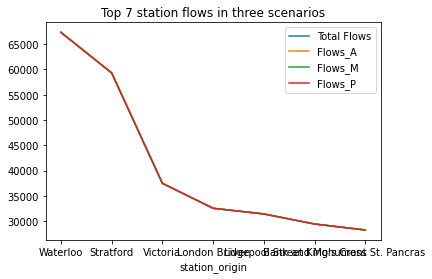

In [315]:
lines = df_plot1.plot.line()
plt.title("Top 7 station flows in three scenarios")

In [304]:
df_plot2=df_com[100:108]

Text(0.5, 1.0, ' #100-108 station flows in three scenarios')

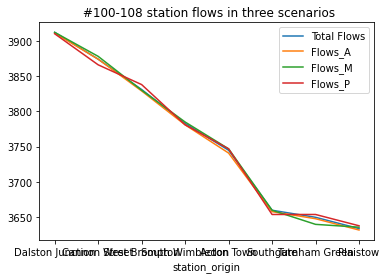

In [314]:
lines = df_plot2.plot.line()
plt.title(" #100-108 station flows in three scenarios")

In [306]:
df_plot3=df_com[200:208]

Text(0.5, 1.0, ' #200-208 station flows in three scenarios')

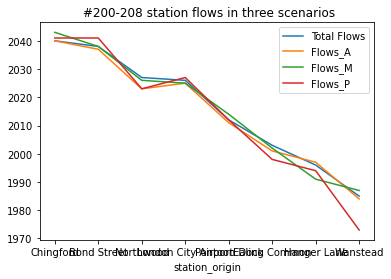

In [313]:
lines = df_plot3.plot.line()
plt.title(" #200-208 station flows in three scenarios")

In [316]:
df_plot4=df_com[350:358]

Text(0.5, 1.0, ' #350-358 station flows in three scenarios')

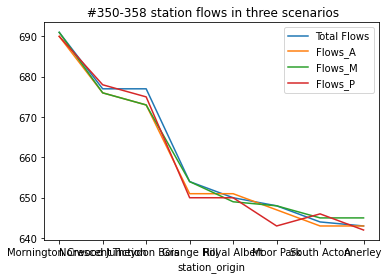

In [318]:
lines = df_plot4.plot.line()
plt.title(" #350-358 station flows in three scenarios")